### Assignment 2:

1. Split the data randomly into two and apply k-means using two, three and four as the number of clusters as we did in our discussion of the consistency in this checkpoint. Assess the consistency of the solutions using visualization. Which one does seem to be the best one?
2. Apply k-means on the whole dataset by setting k is equal two, three and four and get ARI score for each of them. Which model is the best?
3. Apply k-means on the whole dataset by setting k is equal two, three and four and get silhouette coefficient for each of them. Which model is the best?

In [30]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn import metrics
from sqlalchemy import create_engine
import warnings
warnings.filterwarnings("ignore")

In [31]:
postgres_user = 'dsbc_student'
postgres_pw = '7*.8G9QH21'
postgres_host = '142.93.121.174'
postgres_port = '5432'
postgres_db = 'heartdisease'

engine = create_engine('postgresql://{}:{}@{}:{}/{}'.format(
    postgres_user, postgres_pw, postgres_host, postgres_port, postgres_db))
heartdisease_df = pd.read_sql_query('select * from heartdisease',con=engine)

# no need for an open connection, as we're only doing a single query
engine.dispose()

In [32]:
rows = heartdisease_df.shape[0] - heartdisease_df.shape[0] % 2
df = heartdisease_df.iloc[:rows, :]

# Break into a set of features and a variable for the known outcome.
X = df.iloc[:, :13]
y = df.iloc[:, 13]

# Replace some random string values.
X = X.replace(to_replace='?', value=0)

# Binarize y so that 1 means heart disease diagnosis and 0 means no diagnosis.
y = np.where(y > 0, 0, 1)

# Normalize
X_std = StandardScaler().fit_transform(X)

# Data frame to store features and predicted cluster memberships.
ypred = pd.DataFrame()

# Create the two-feature PCA for graphing purposes.
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_std)

# Split the data into four equally-sized samples. First we break it in half:
X_half1, X_half2, X_pcahalf1, X_pcahalf2 = train_test_split(
    X_std,
    X_pca,
    test_size=0.5,
    random_state=123)

# Pass a list of tuples and a counter that increments each time we go
# through the loop. The tuples are the data to be used by k-means,
# and the PCA-derived features for graphing. We use k-means to fit a
# model to the data, then store the predicted values and the two-feature
# PCA solution in the data frame.
for counter, data in enumerate([
    (X_half1, X_pcahalf1),
    (X_half2, X_pcahalf2)]):
    
    # Put the features into ypred.
    ypred['pca_f1' + '_sample' + str(counter)] = data[1][:, 0]
    ypred['pca_f2' + '_sample' + str(counter)] = data[1][:, 1]
    
    # Generate cluster predictions and store them for clusters 2 to 4.
    for nclust in range(2, 5):
        pred = KMeans(n_clusters=nclust, random_state=123).fit_predict(data[0])
        ypred['clust' + str(nclust) + '_sample' + str(counter)] = pred

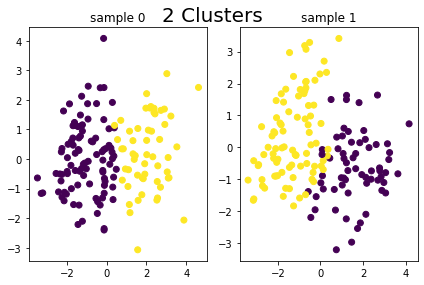

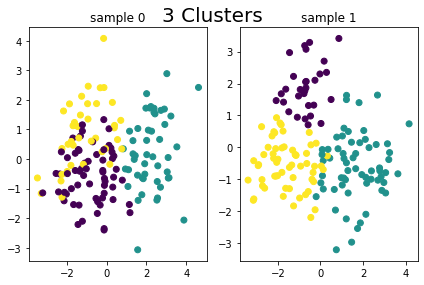

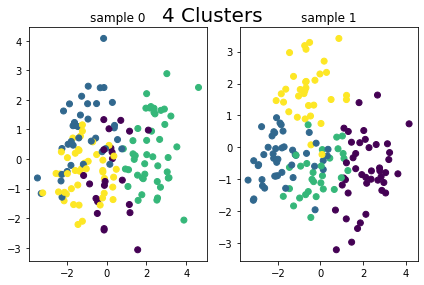

In [33]:
# For each  number of clusters, plot the clusters using the
# pca features for each sample.
for cluster in range(2, 5):
    
    # Make a grid of subplots.
    f, axarr = plt.subplots(1, 2)
    
    # Make a plot for each sample.
    for i in range(2):
        
        # PCA-created features.
        x_sub = ypred['pca_f1_sample{}'.format(i)]
        y_sub = ypred['pca_f2_sample{}'.format(i)]
        
        # Cluster assignments.
        c = ypred['clust{}_sample{}'.format(cluster, i)]
        
        # Assign the subplot to its place on the grid.
        axarr[i].scatter(x_sub, y_sub, c=c)
        axarr[i].set_title('sample {}'.format(i))
    
    # Space out the plots so that the headings don't overlap axis values.
    plt.suptitle('{} Clusters'.format(cluster), fontsize=20)
    plt.tight_layout()
    plt.show()

From above we can see that, with cluster 2 gives us better consistency.

2. ARI:

In [34]:
from sklearn.metrics.cluster import adjusted_rand_score
pred1 = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
pred2 = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
pred3 = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)

print("ARI for K=2 :{:0.2f} ".format(adjusted_rand_score(y, pred1)))
print("ARI for K=3 :{:0.2f} ".format(adjusted_rand_score(y, pred2)))
print("ARI for K=4 :{:0.2f} ".format(adjusted_rand_score(y, pred3)))

ARI for K=2 :0.44 
ARI for K=3 :0.28 
ARI for K=4 :0.20 


From above we can see that for k means of 2 got higher ARI which is better than other two.

In [35]:

pred1 = KMeans(n_clusters=2, random_state=123).fit_predict(X_std)
pred2 = KMeans(n_clusters=3, random_state=123).fit_predict(X_std)
pred3 = KMeans(n_clusters=4, random_state=123).fit_predict(X_std)

print("silhouette_score for K=2 :{:0.2f} ".format(metrics.silhouette_score(X_std, pred1, metric='euclidean')))
print("silhouette_score for K=3 :{:0.2f} ".format(metrics.silhouette_score(X_std, pred2, metric='euclidean')))
print("silhouette_score for K=4 :{:0.2f} ".format(metrics.silhouette_score(X_std, pred3, metric='euclidean')))

silhouette_score for K=2 :0.17 
silhouette_score for K=3 :0.13 
silhouette_score for K=4 :0.13 


K means of 2 gives better silhouette score.
So K= 2 is a best model.

## Assignment 3:
- Produce dendrograms for the heart disease dataset using three different linkage methods: complete, average and ward. Which linkage method do you think produces more reasonable result?
- Apply agglomerative clustering to the heart disease data by setting n_clusters=2. Try the three linkage methods above and get ARI and silhouette scores for each of your solutions. Compare the results with each other and with that of the k-means solution that you implemented in the assignment of the previous checkpoint. Which algorithm and setting does perform better?

### Using complete linkage:

In [36]:
from sklearn.cluster import AgglomerativeClustering
from scipy.cluster.hierarchy import dendrogram, linkage
# Defining the agglomerative clustering
agg_cluster = AgglomerativeClustering(linkage='complete', 
                                      affinity='cosine',
                                      n_clusters=2)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

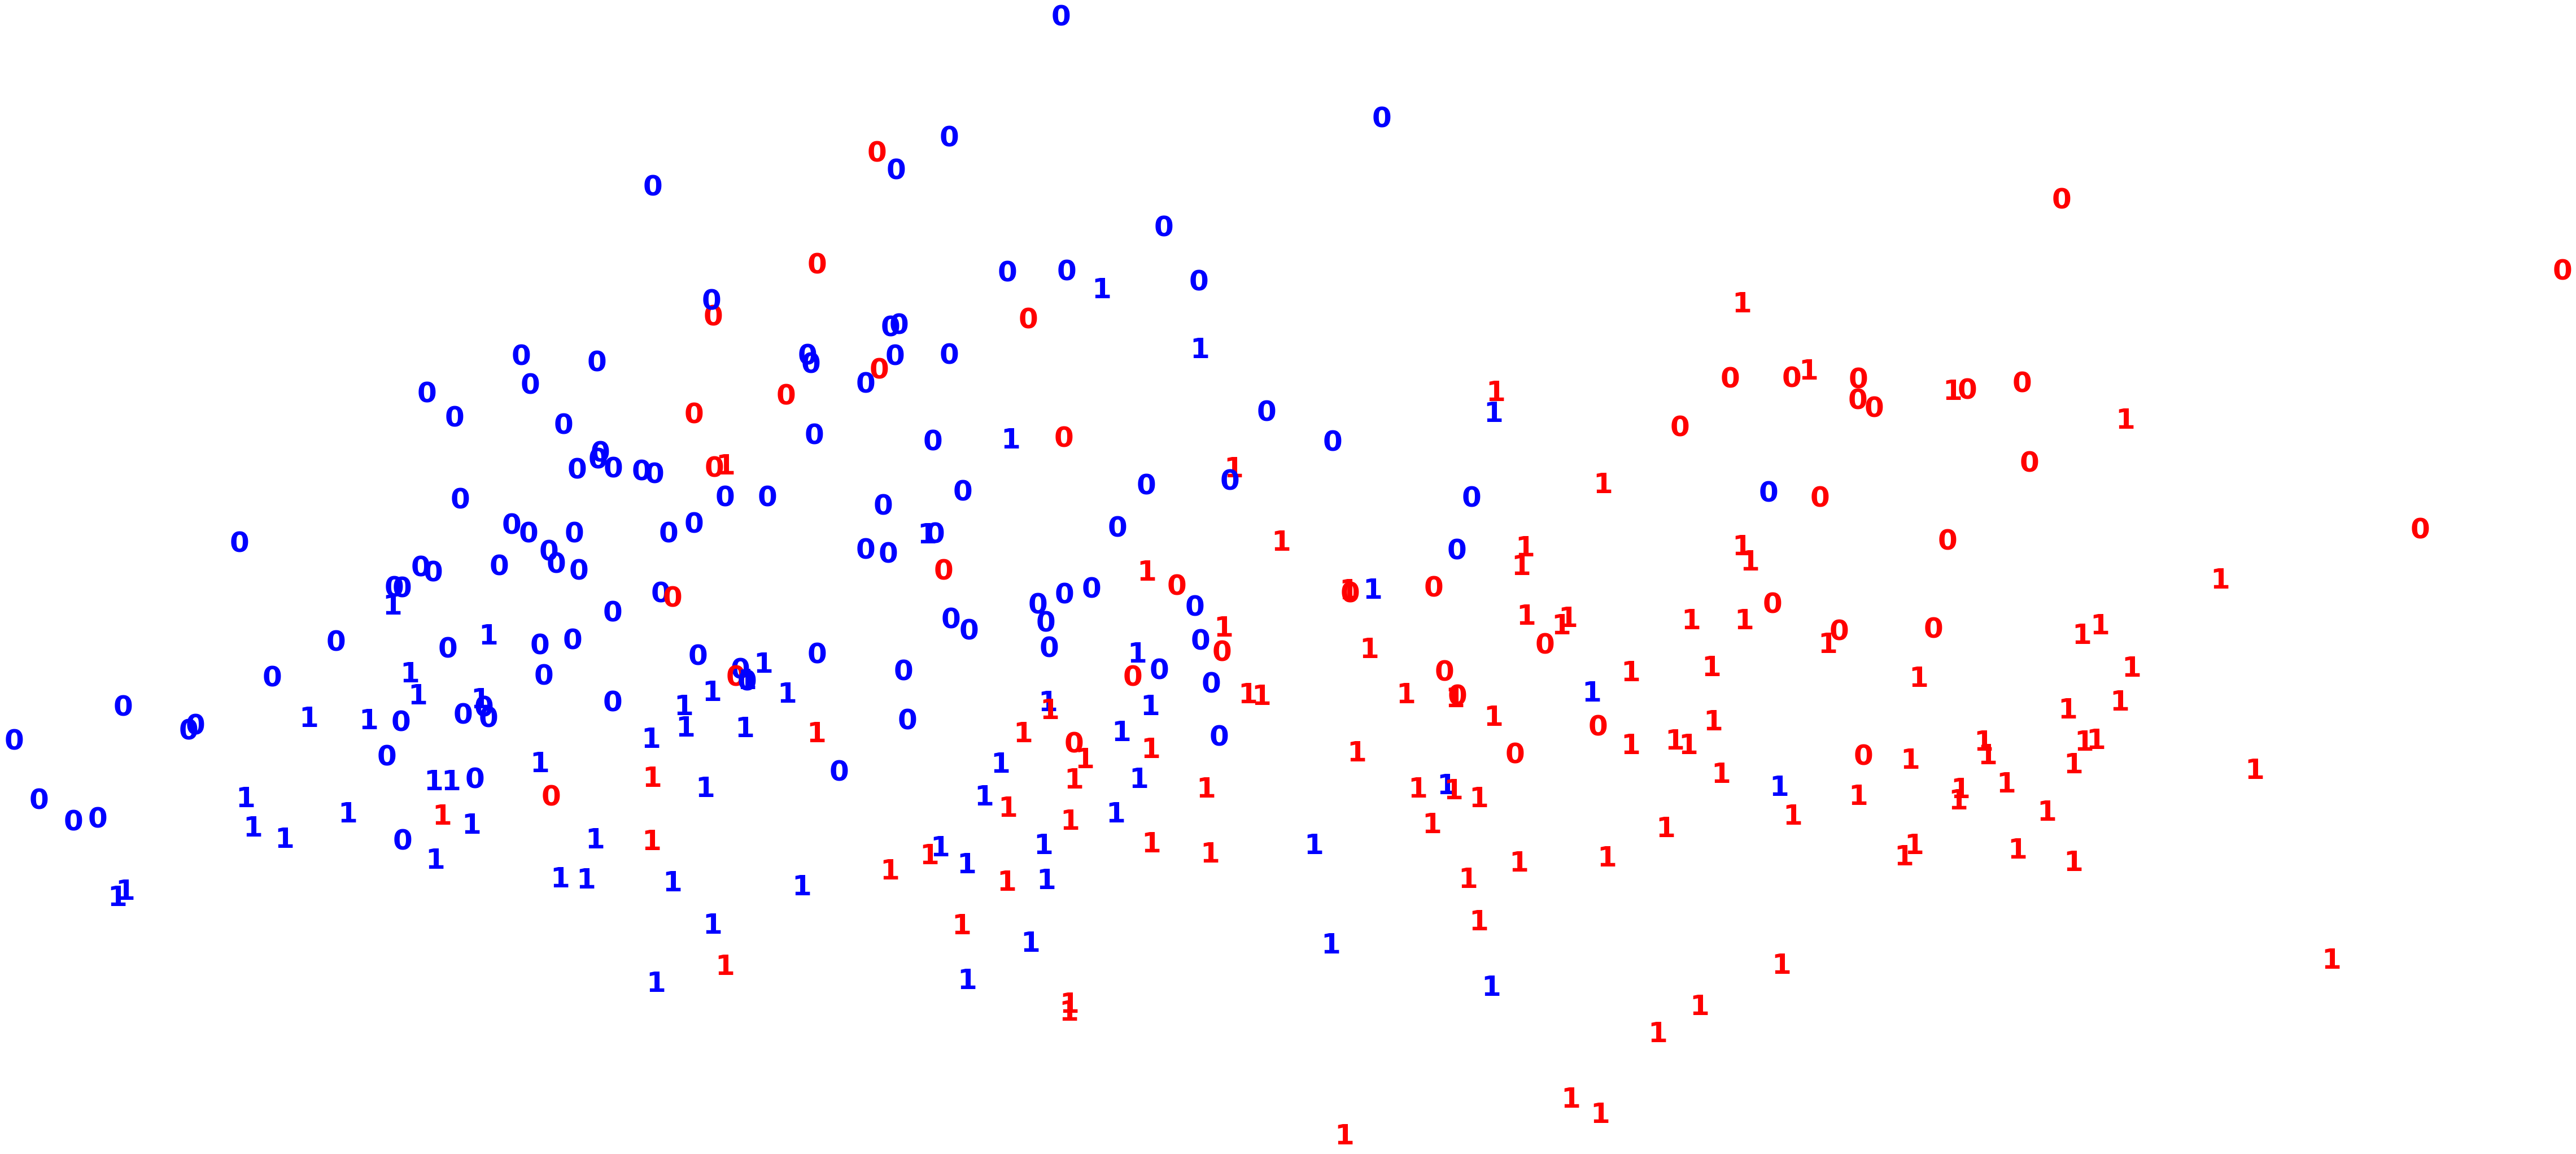

Adjusted Rand Index of the Agglomerative Clustering solution w/ complete linkage: 0.10233468474116167
The silhoutte score of the Agglomerative Clustering solution w/ complete linkage: 0.07445588349053094


In [37]:
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

print("Adjusted Rand Index of the Agglomerative Clustering solution w/ complete linkage: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhoutte score of the Agglomerative Clustering solution w/ complete linkage: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

### Using Average linkage:

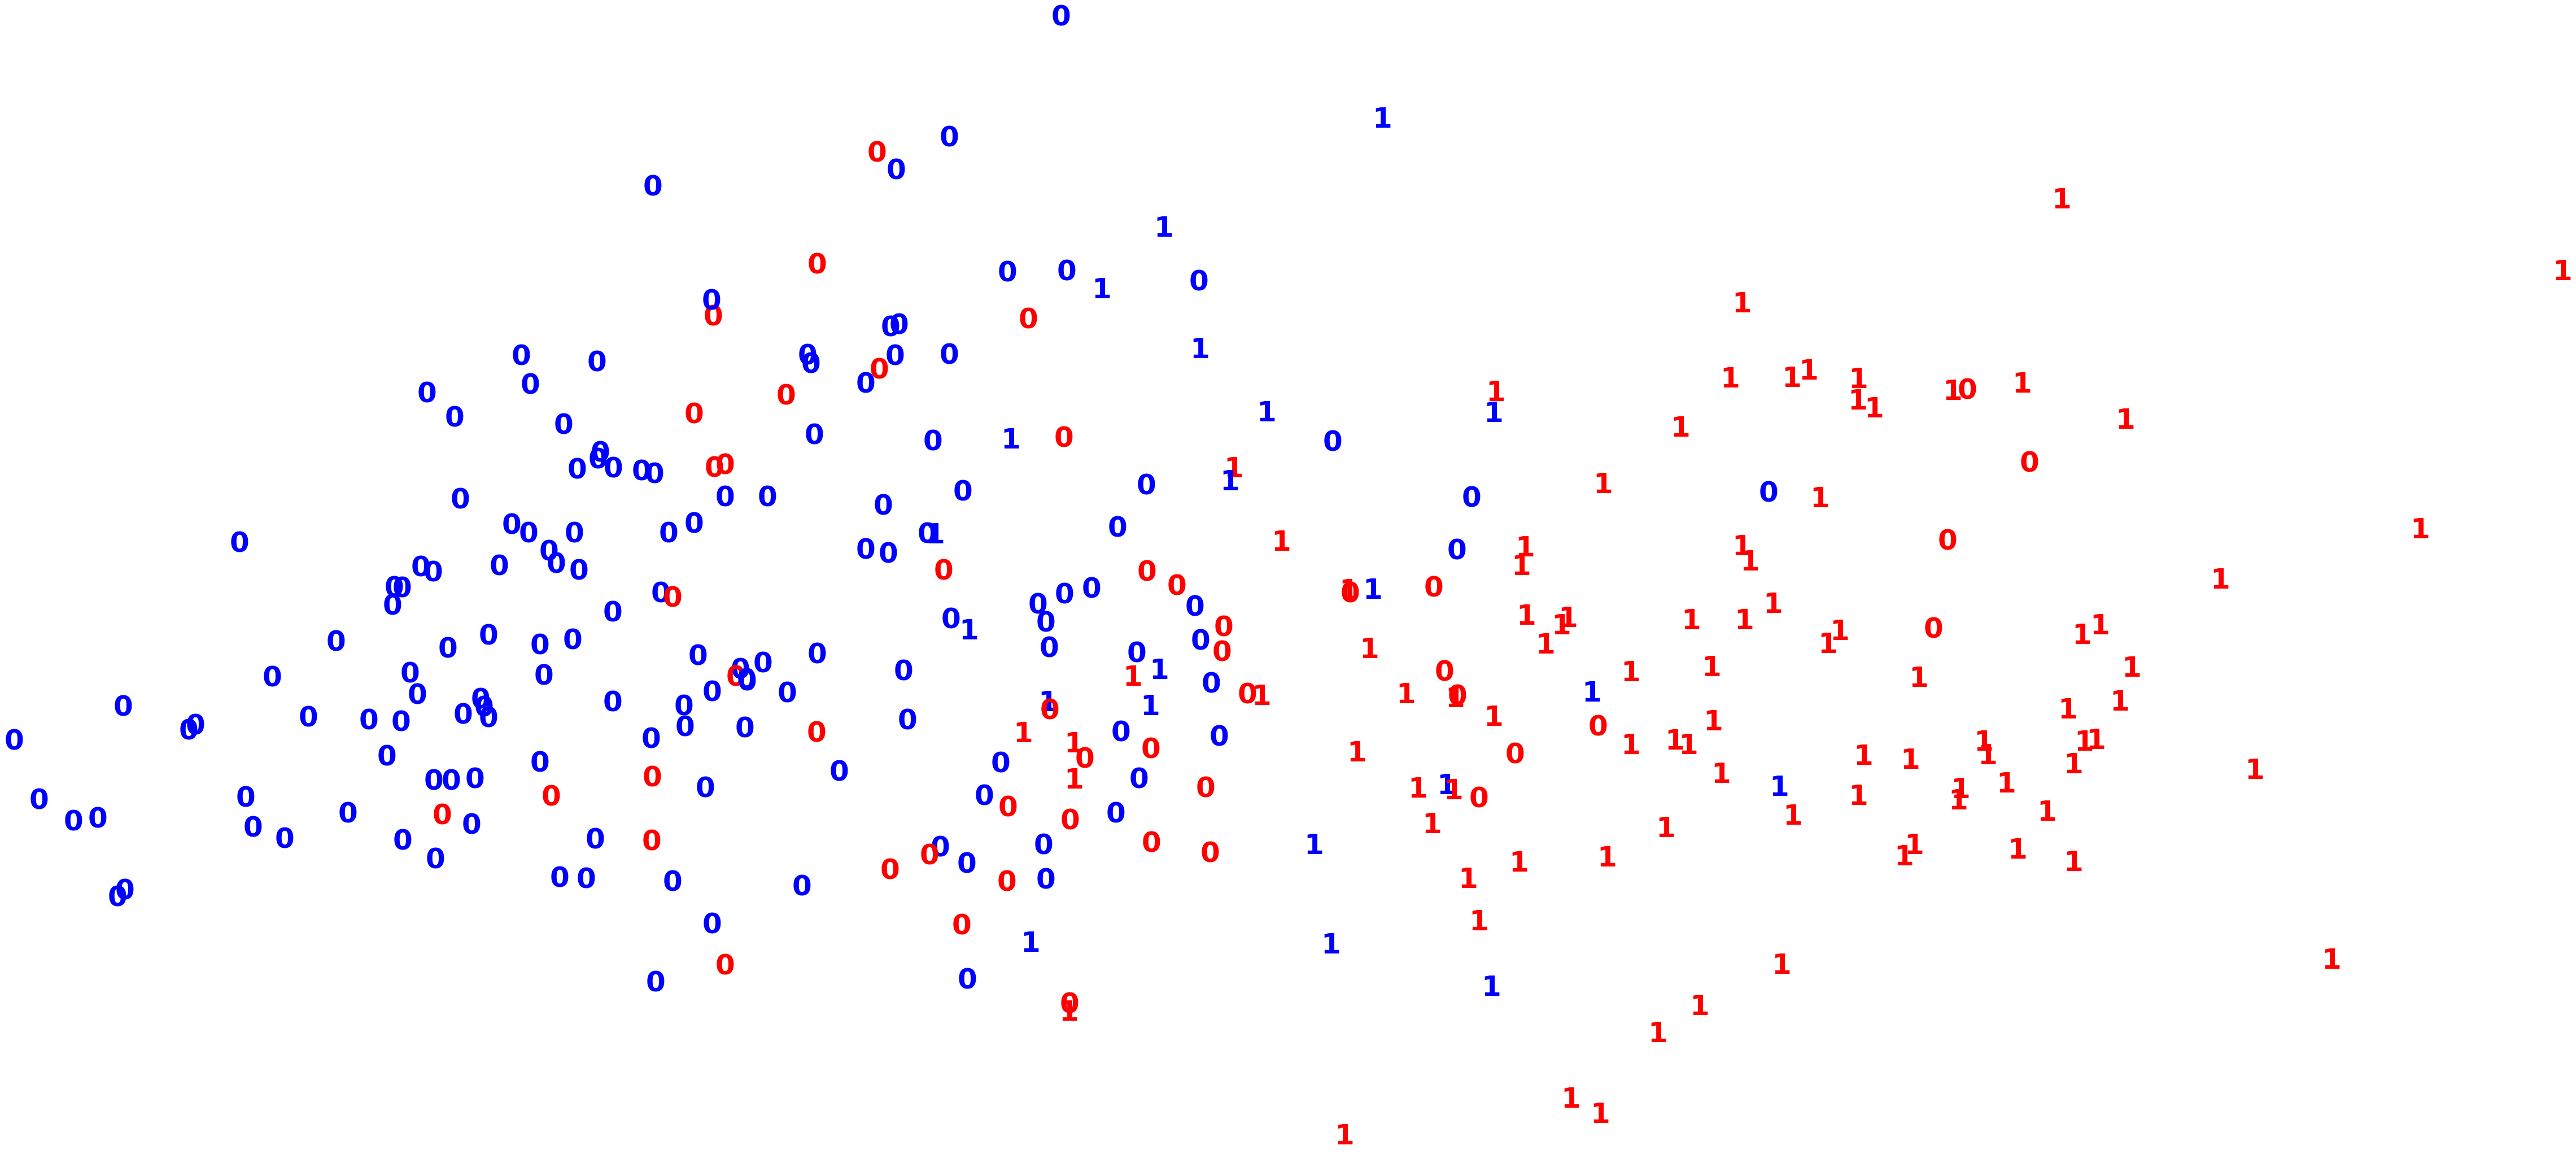

Adjusted Rand Index of the Agglomerative Clustering solution w/ average linkage: 0.29242115793299467
The silhoutte score of the Agglomerative Clustering solution w/ average linkage: 0.14746387683622914


In [38]:
agg_cluster = AgglomerativeClustering(linkage='average', 
                                      affinity='cosine',
                                      n_clusters=2)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()


print("Adjusted Rand Index of the Agglomerative Clustering solution w/ average linkage: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhoutte score of the Agglomerative Clustering solution w/ average linkage: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

### Using ward linkage:

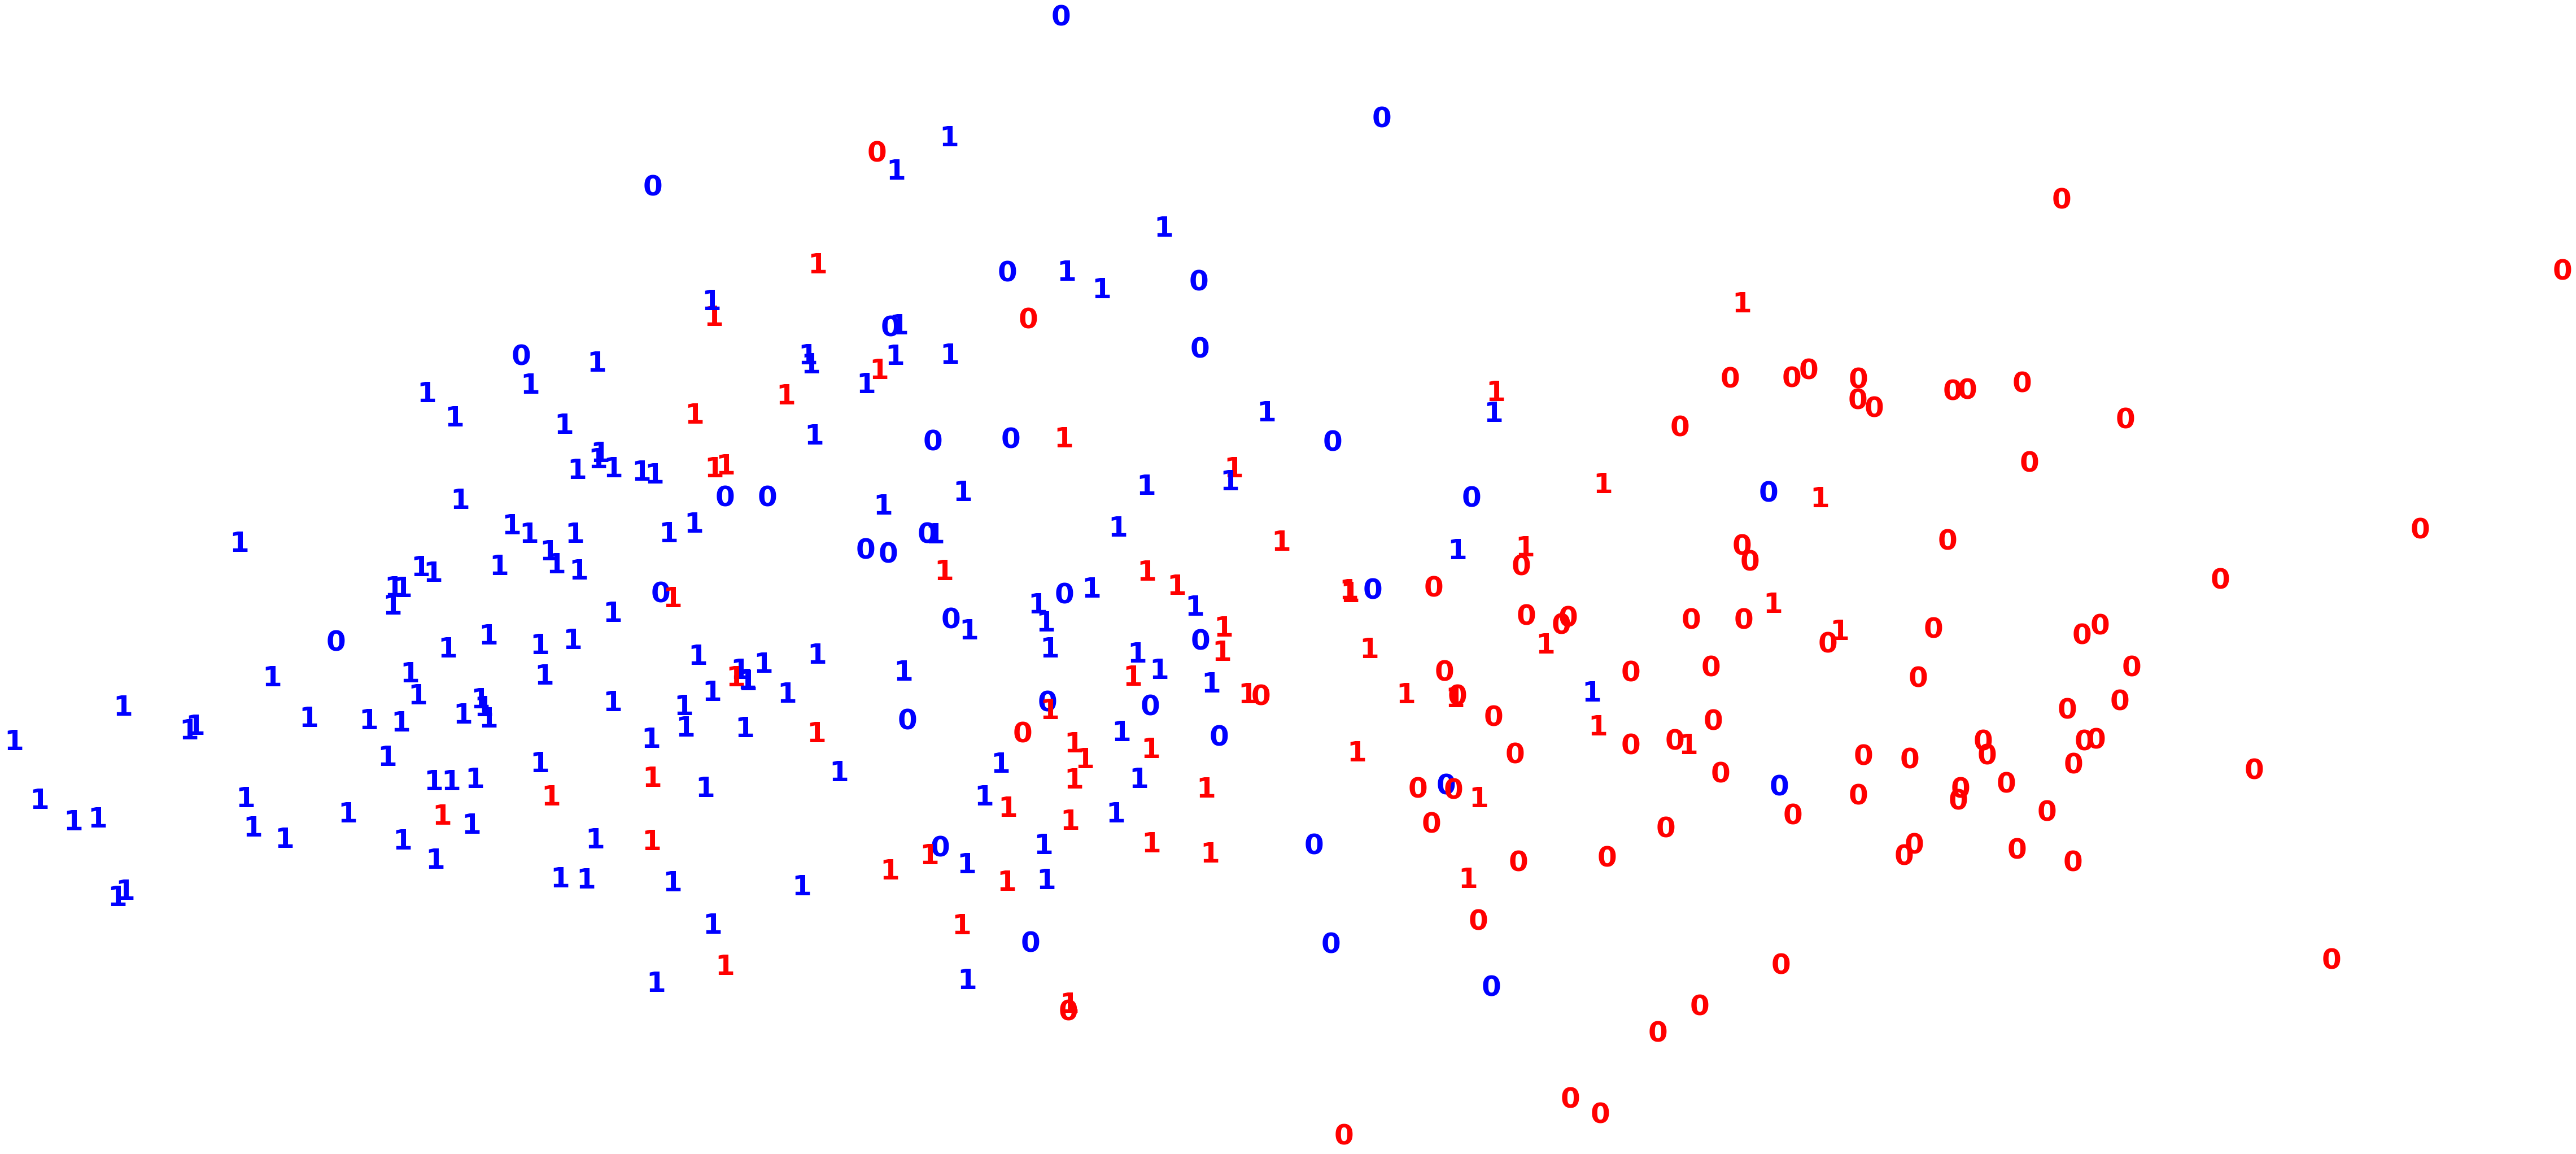

Adjusted Rand Index of the Agglomerative Clustering solution w/ average linkage: 0.14457486386986915
The silhoutte score of the Agglomerative Clustering solution w/ average linkage: 0.1377396413078055


In [39]:
agg_cluster = AgglomerativeClustering(linkage='ward', 
                                      affinity='euclidean',
                                      n_clusters=2)

# Fit model
clusters = agg_cluster.fit_predict(X_std)

pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()


print("Adjusted Rand Index of the Agglomerative Clustering solution w/ ward linkage: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhoutte score of the Agglomerative Clustering solution w/ ward linkage: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

Observation:
- ARI and Silhoutte score is higher when k-means was used than using clustering and different linkage.

### Dendograms using different linkage:

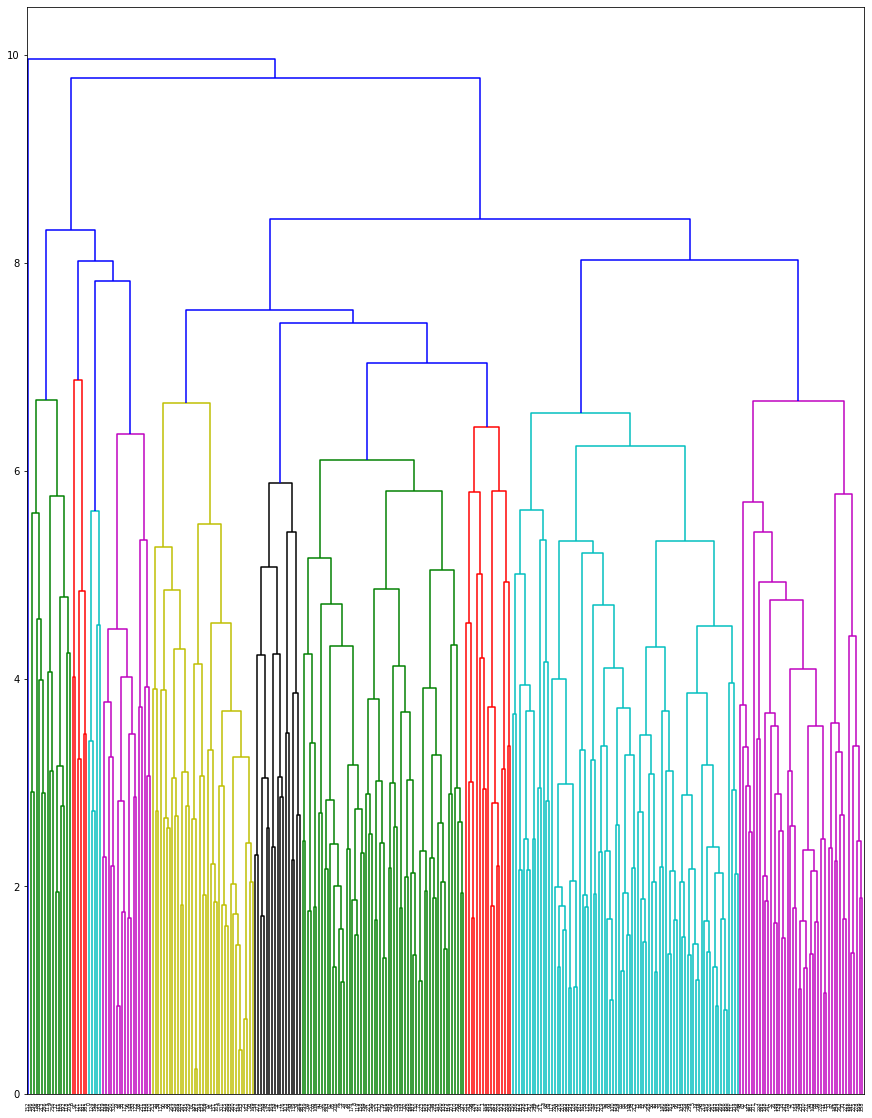

In [40]:
#complete linkage
plt.figure(figsize=(15,20))
dendrogram(linkage(X_std, method='complete'))
plt.show()

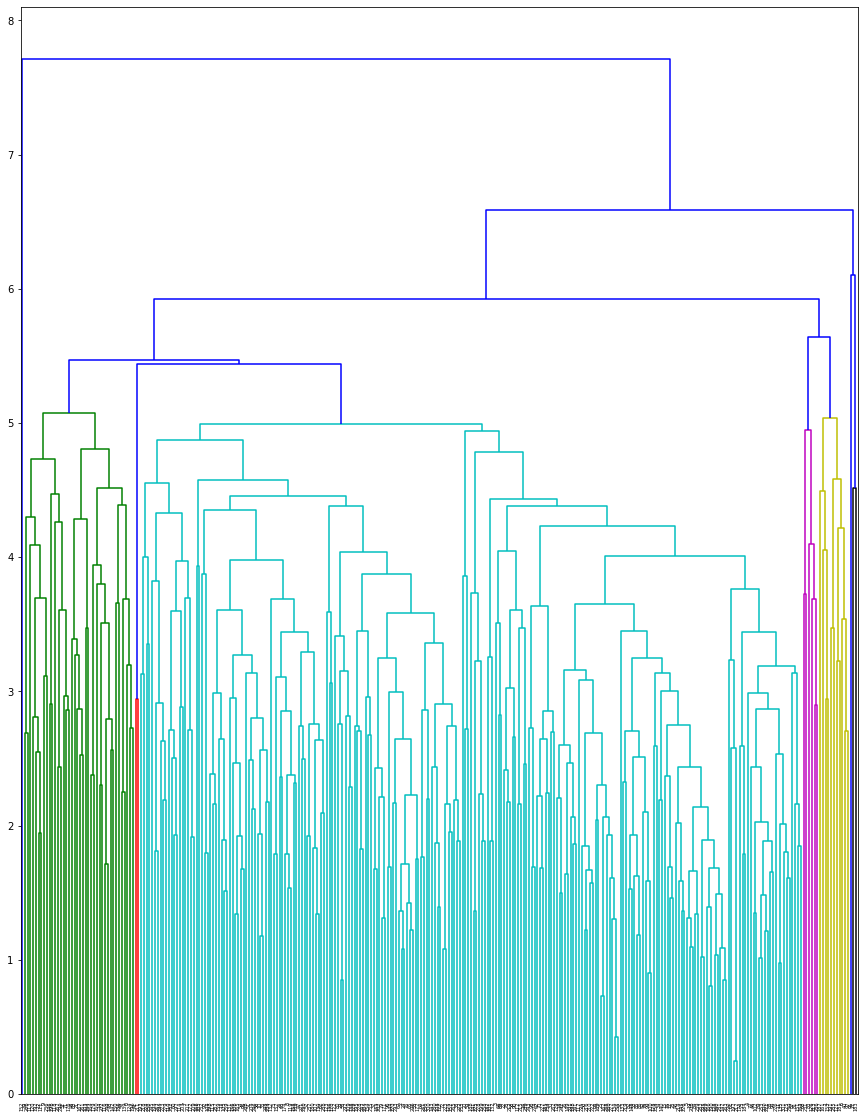

In [41]:
#average linkage
plt.figure(figsize=(15,20))
dendrogram(linkage(X_std, method='average'))
plt.show()

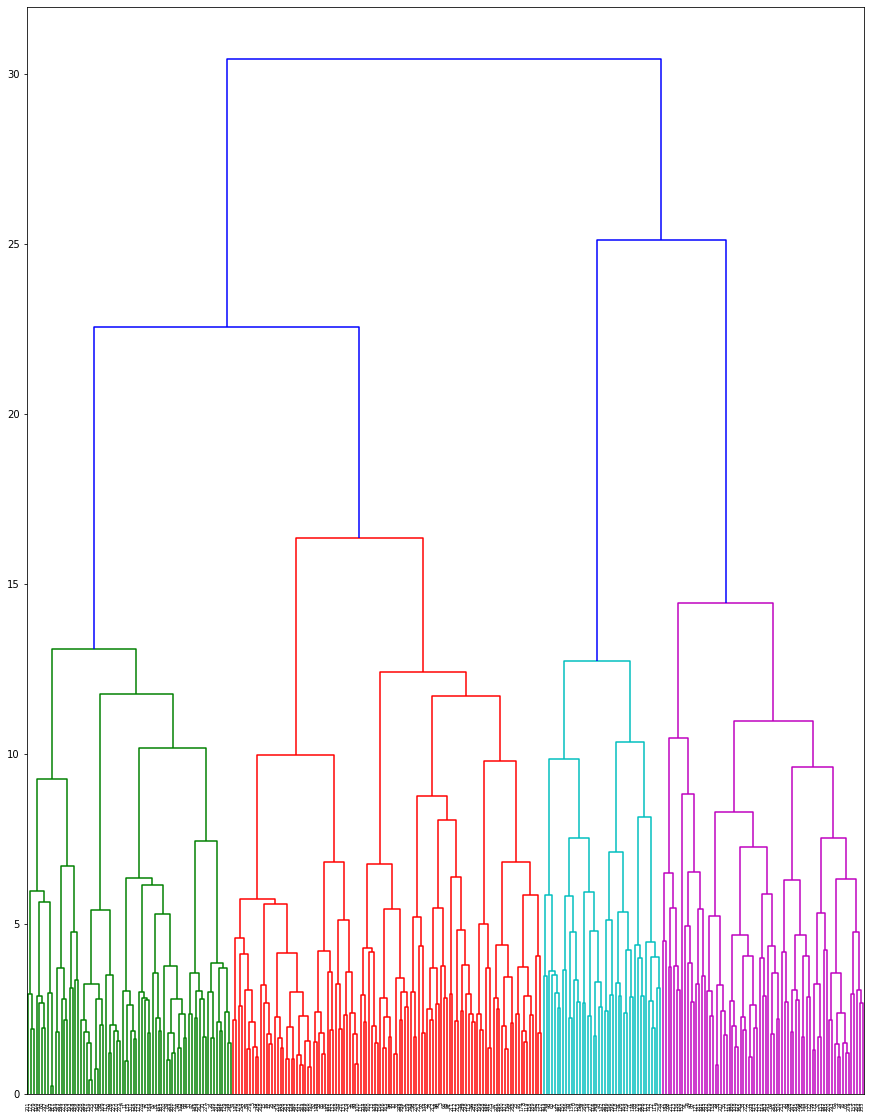

In [42]:
# ward linkage
plt.figure(figsize=(15,20))
dendrogram(linkage(X_std, method='ward'))
plt.show()

Looking dendrogram, I can see that ward linkage done better job than other two, other to is really hard to see observation for two clusters.

## Assignment 4:
- Apply DBSCAN to the heart disease data by trying different values for eps and min_samples parameters. You'll realize that it's really hard to get a two cluster solution using DBSCAN if not impossible.
- Apply DBSCAN by setting parameters eps=1, min_samples=1, metric="euclidean". Then, increase the value of min_samples. What's the effect of increasing min_samples on the number of clusters DBSCAN identifies?
- Apply DBSCAN by setting parameters eps=1, min_samples=1, metric="euclidean". Then, increase the value of eps. What's the effect of increasing eps on the number of clusters DBSCAN identifies?

In [50]:
from sklearn.cluster import DBSCAN

# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=1, min_samples=5)

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)

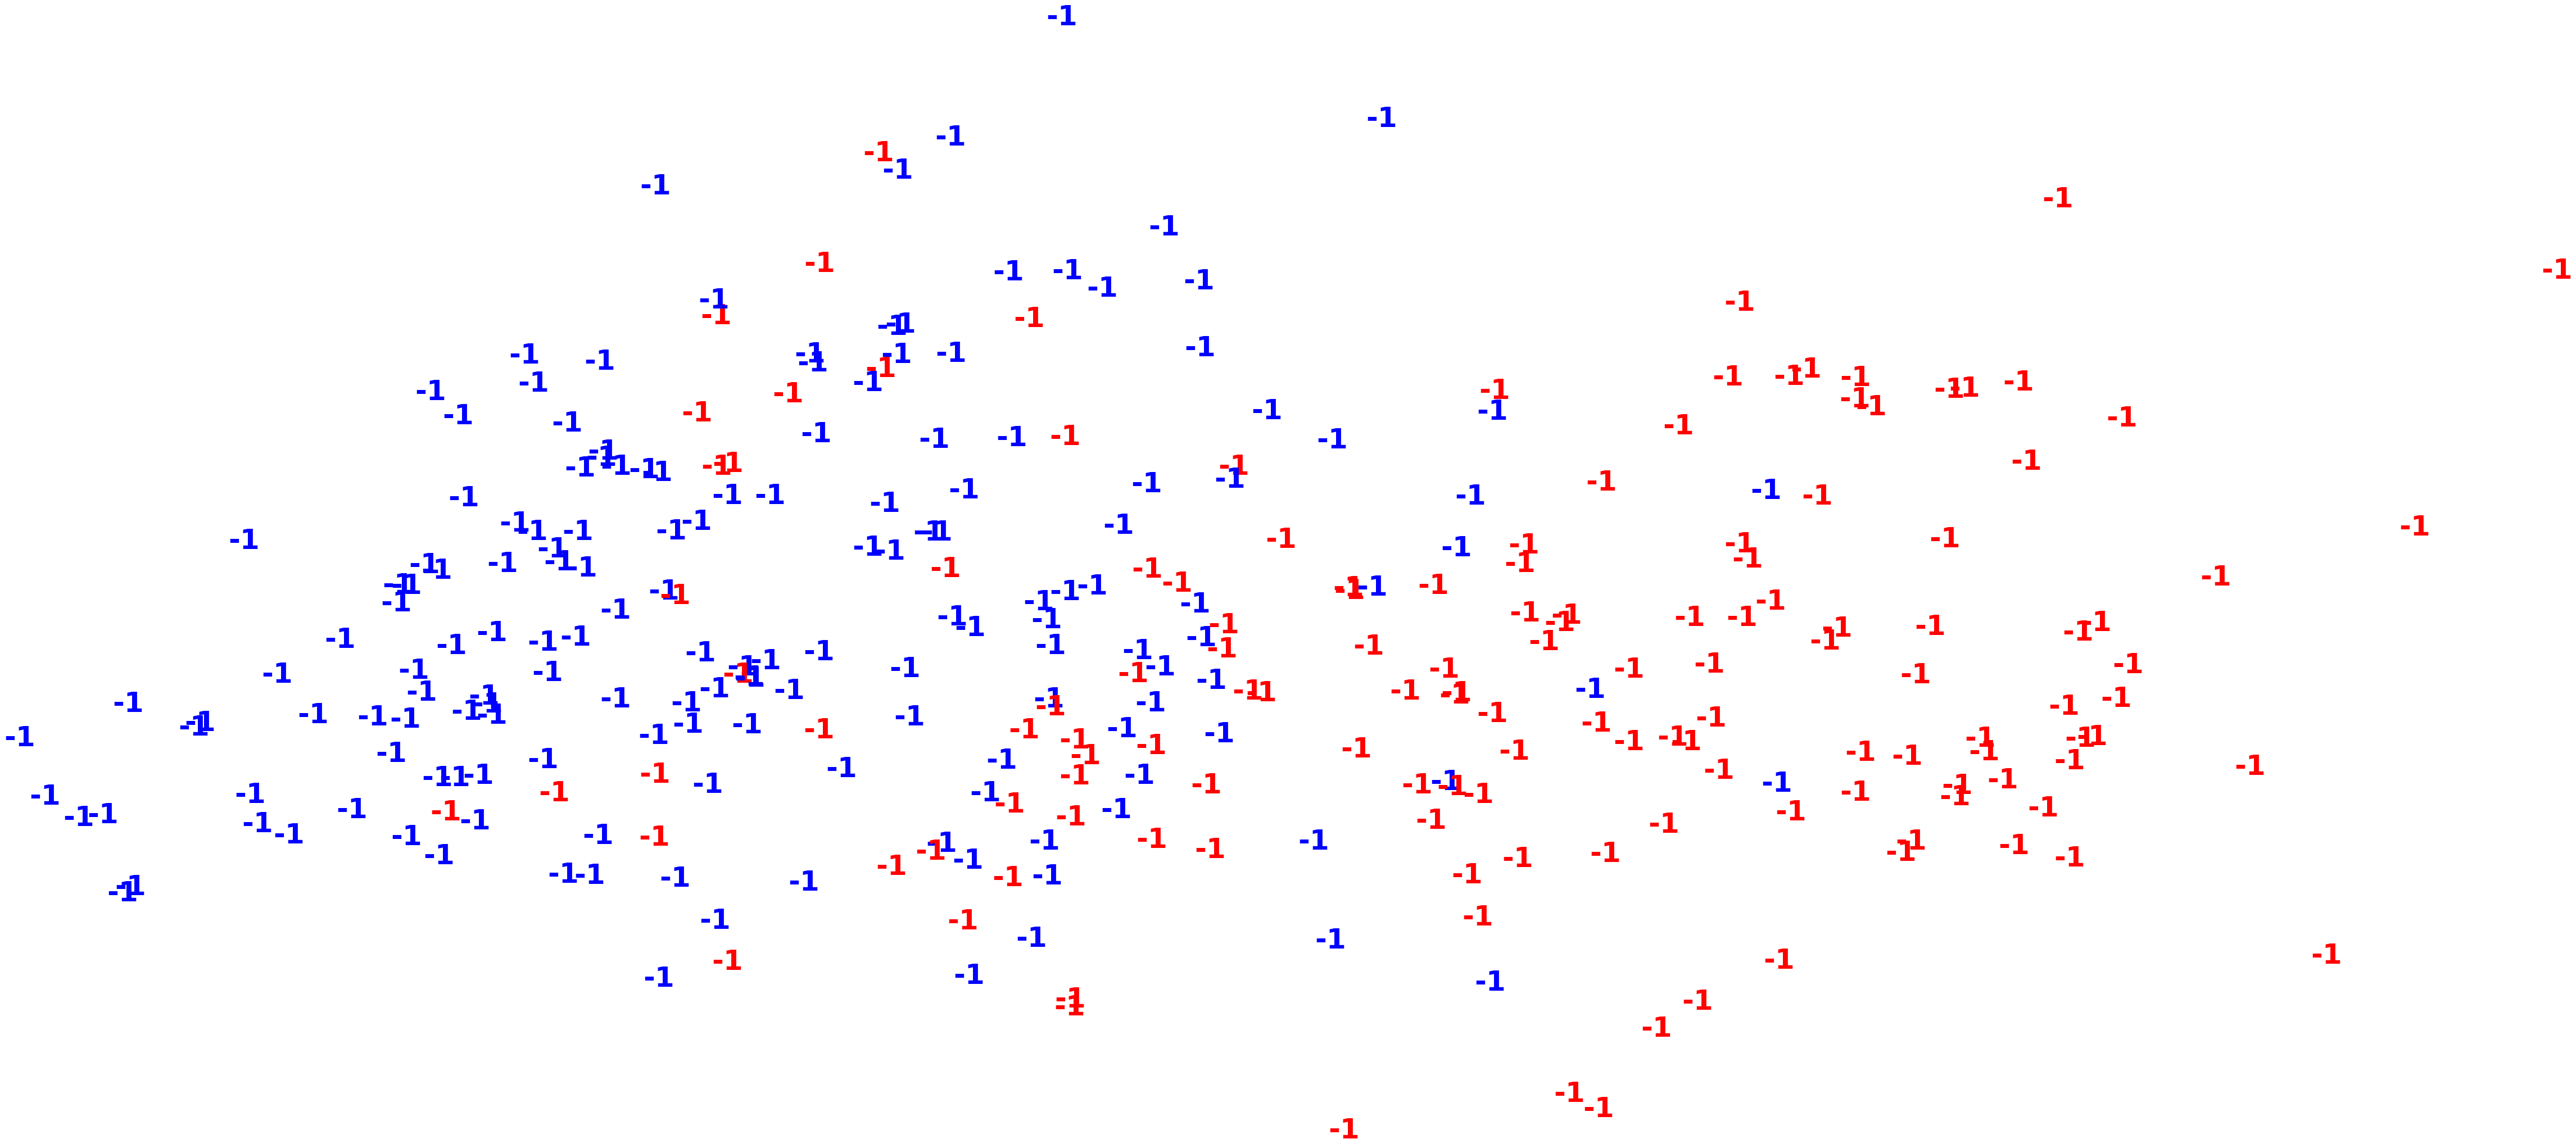

In [51]:
pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()


OBS:
- DBSCAN found all the data as noise.

Apply DBSCAN by setting parameters eps=1, min_samples=1, metric="euclidean". Then, increase the value of min_samples. What's the effect of increasing min_samples on the number of clusters DBSCAN identifies?

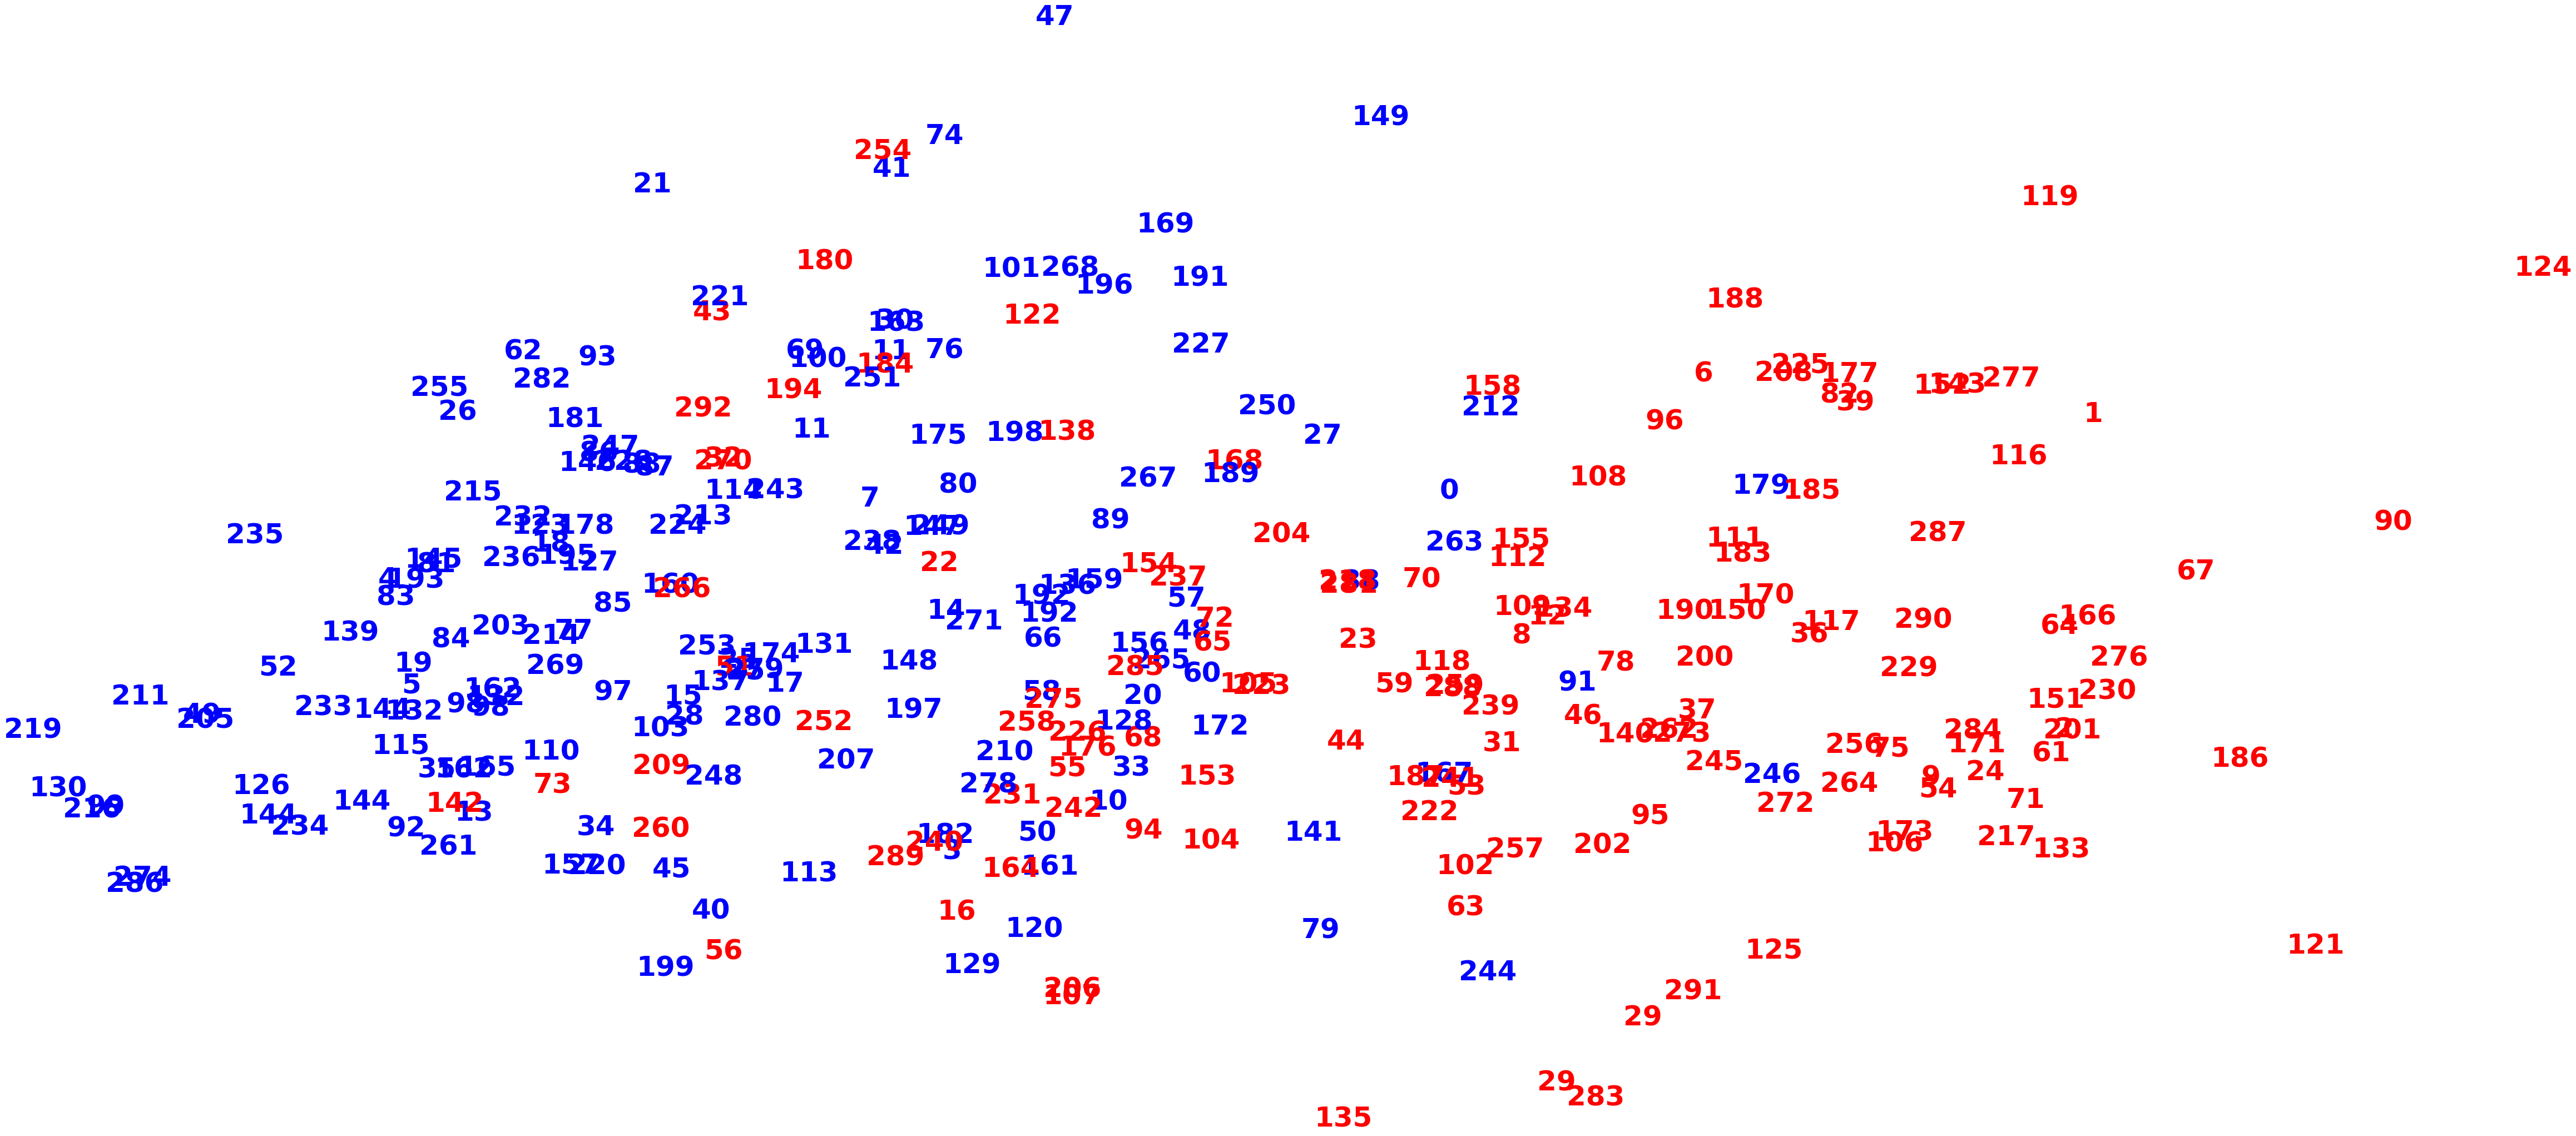

Adjusted Rand Index of the DBSCAN solution: 0.0004373901391973221
The silhouette score of the DBSCAN solution: 0.028156783973862093


In [52]:
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=1, min_samples=1, metric='euclidean')

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)

pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()


print("Adjusted Rand Index of the DBSCAN solution: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

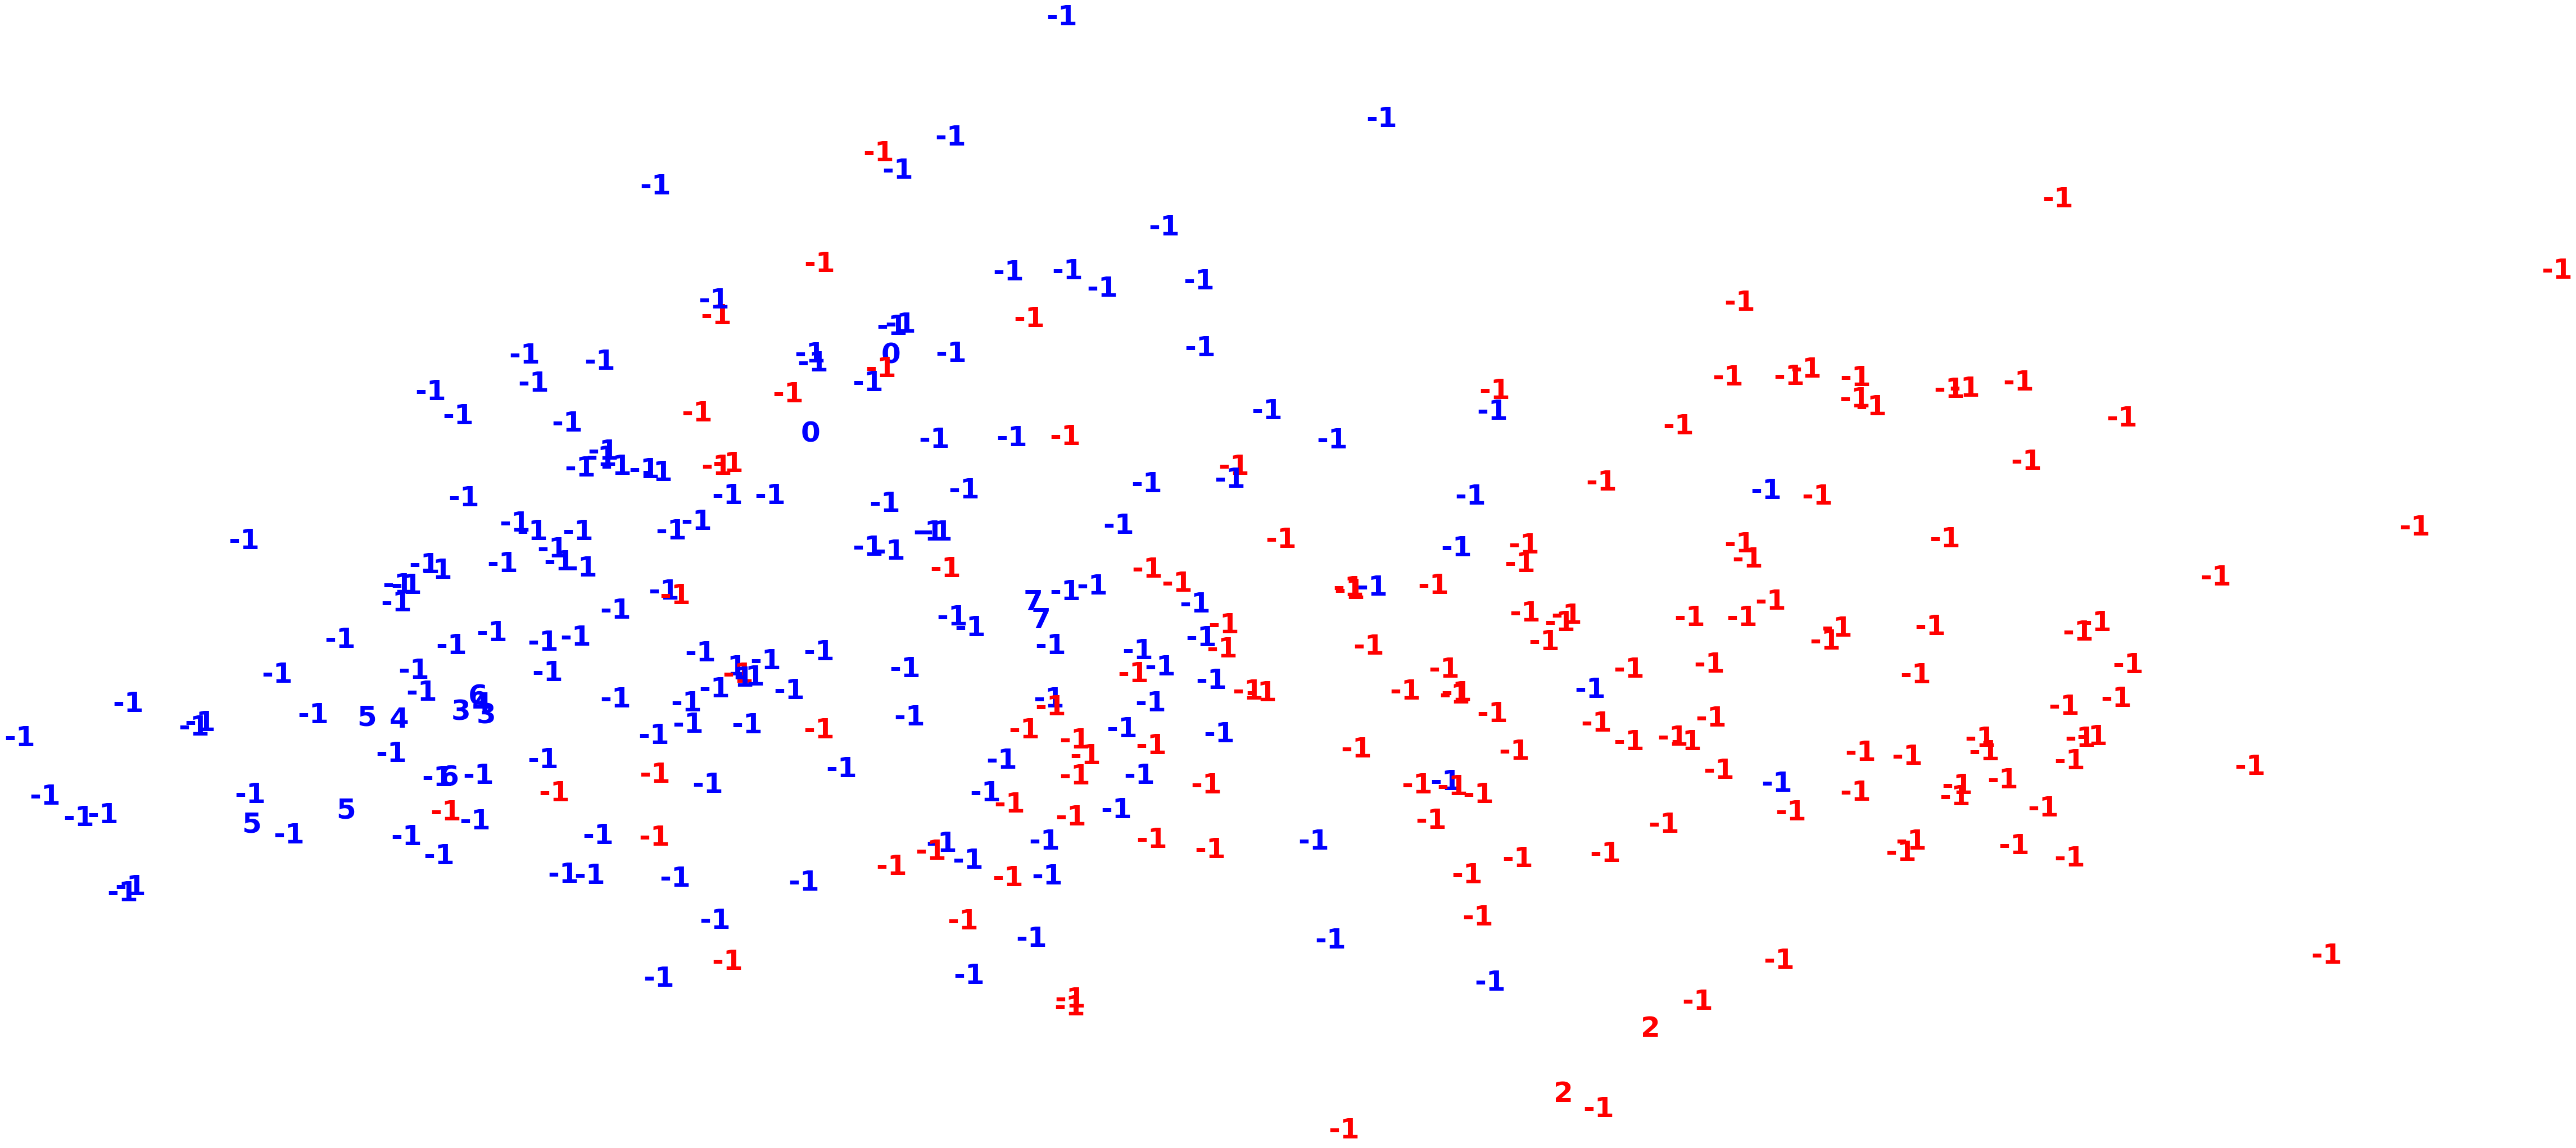

Adjusted Rand Index of the DBSCAN solution: -0.008557532472540695
The silhouette score of the DBSCAN solution: -0.2543456311923248


In [53]:
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=1, min_samples=2, metric='euclidean')

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)

pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()


print("Adjusted Rand Index of the DBSCAN solution: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

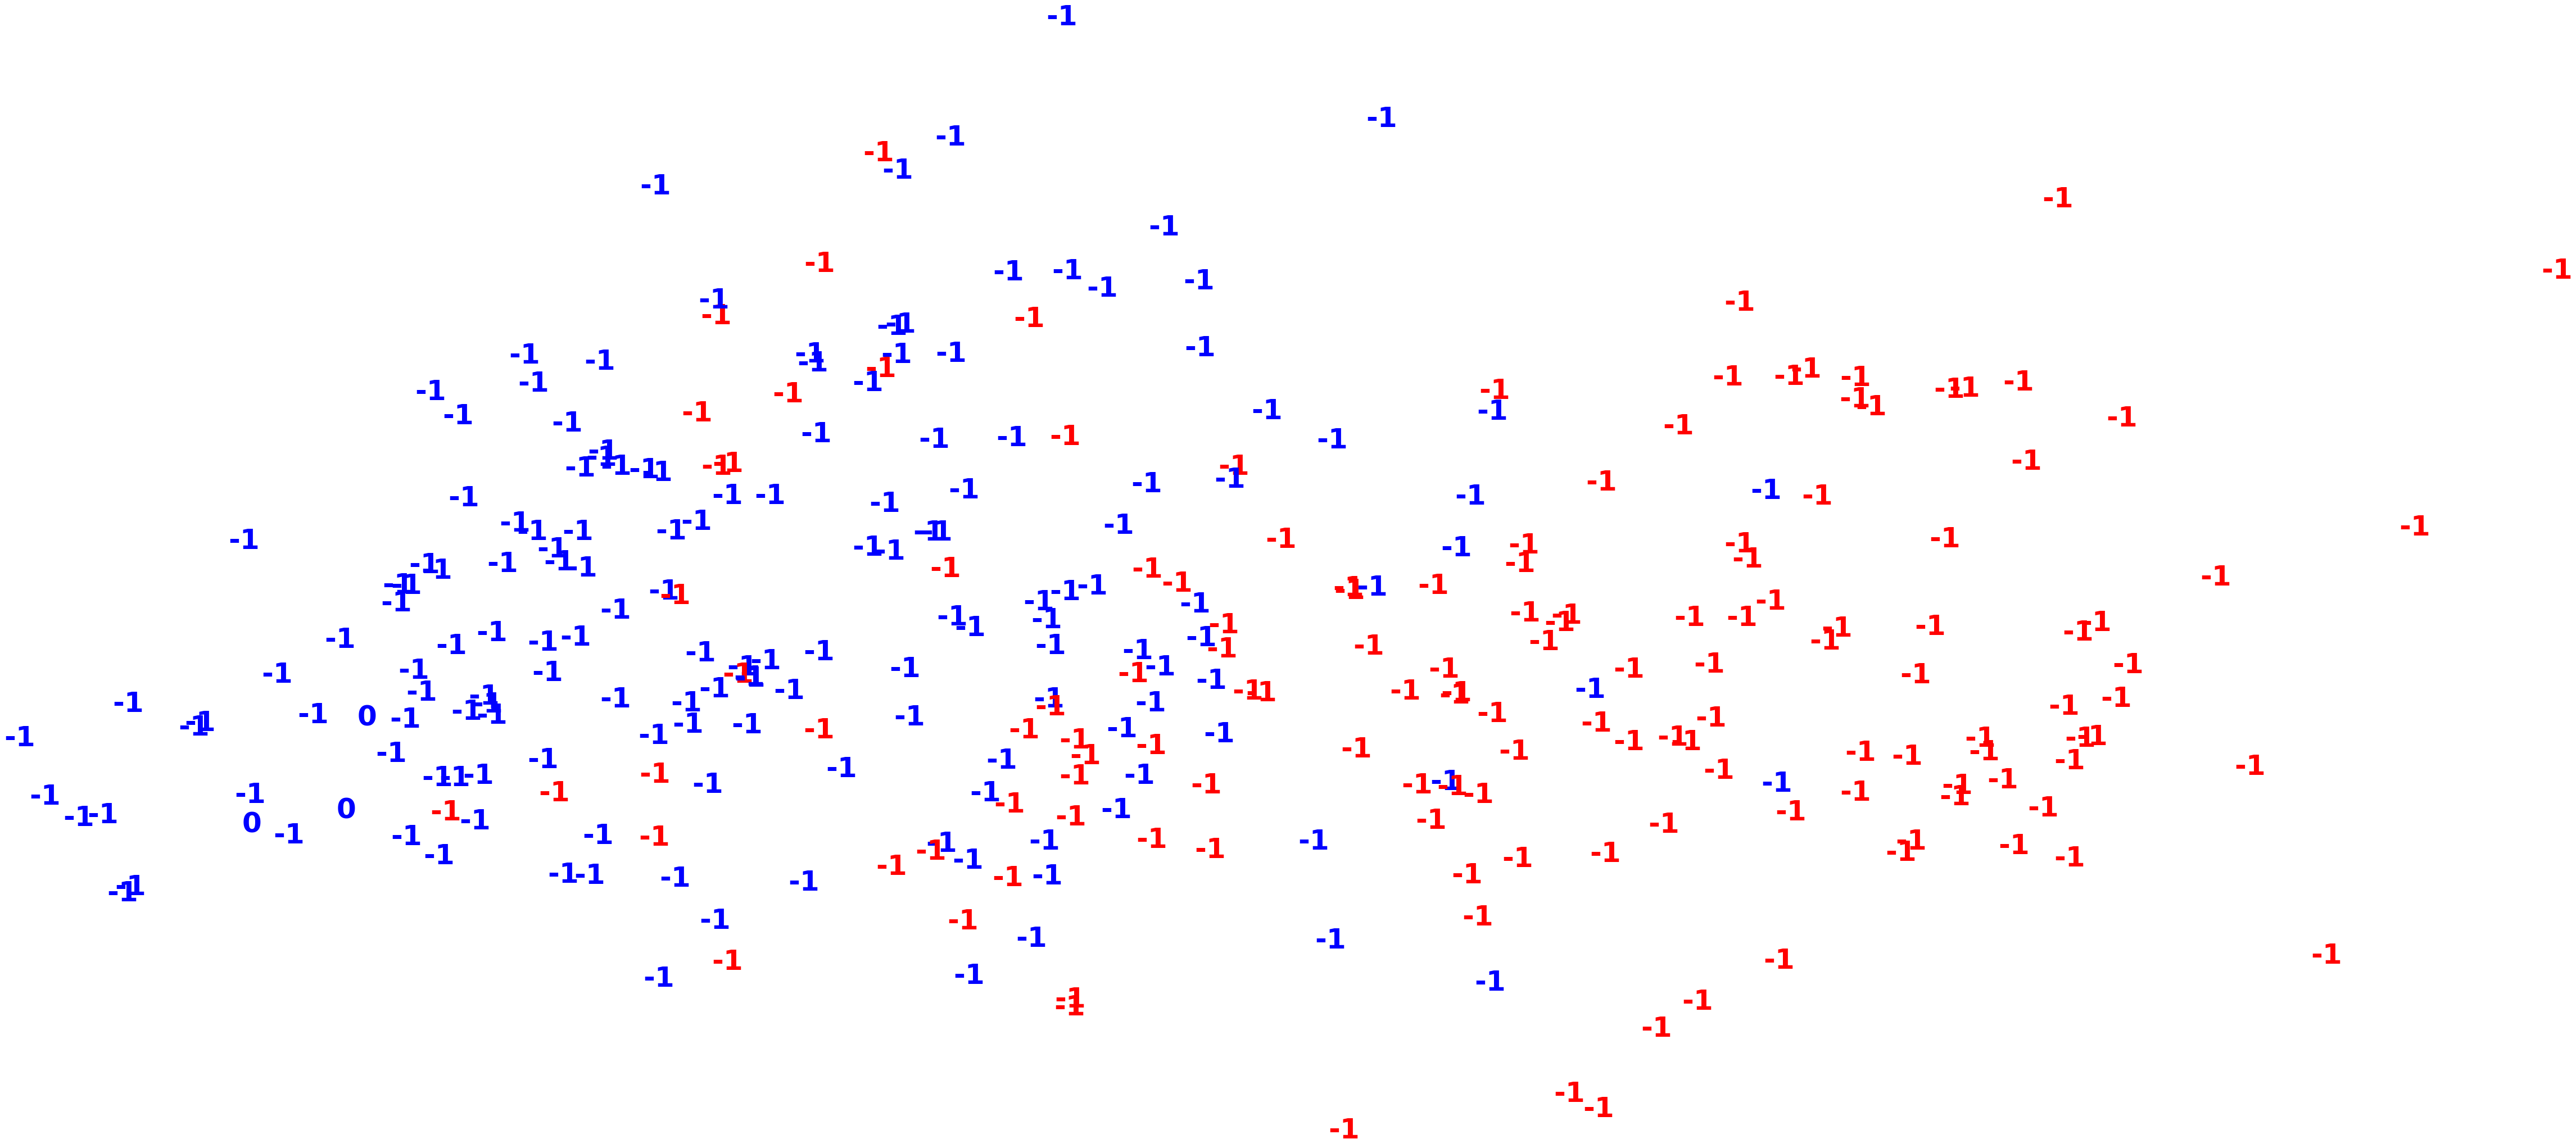

Adjusted Rand Index of the DBSCAN solution: -0.002660945249813766
The silhouette score of the DBSCAN solution: -0.1123388915588819


In [54]:
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=1, min_samples=3, metric='euclidean')

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)

pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()


print("Adjusted Rand Index of the DBSCAN solution: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

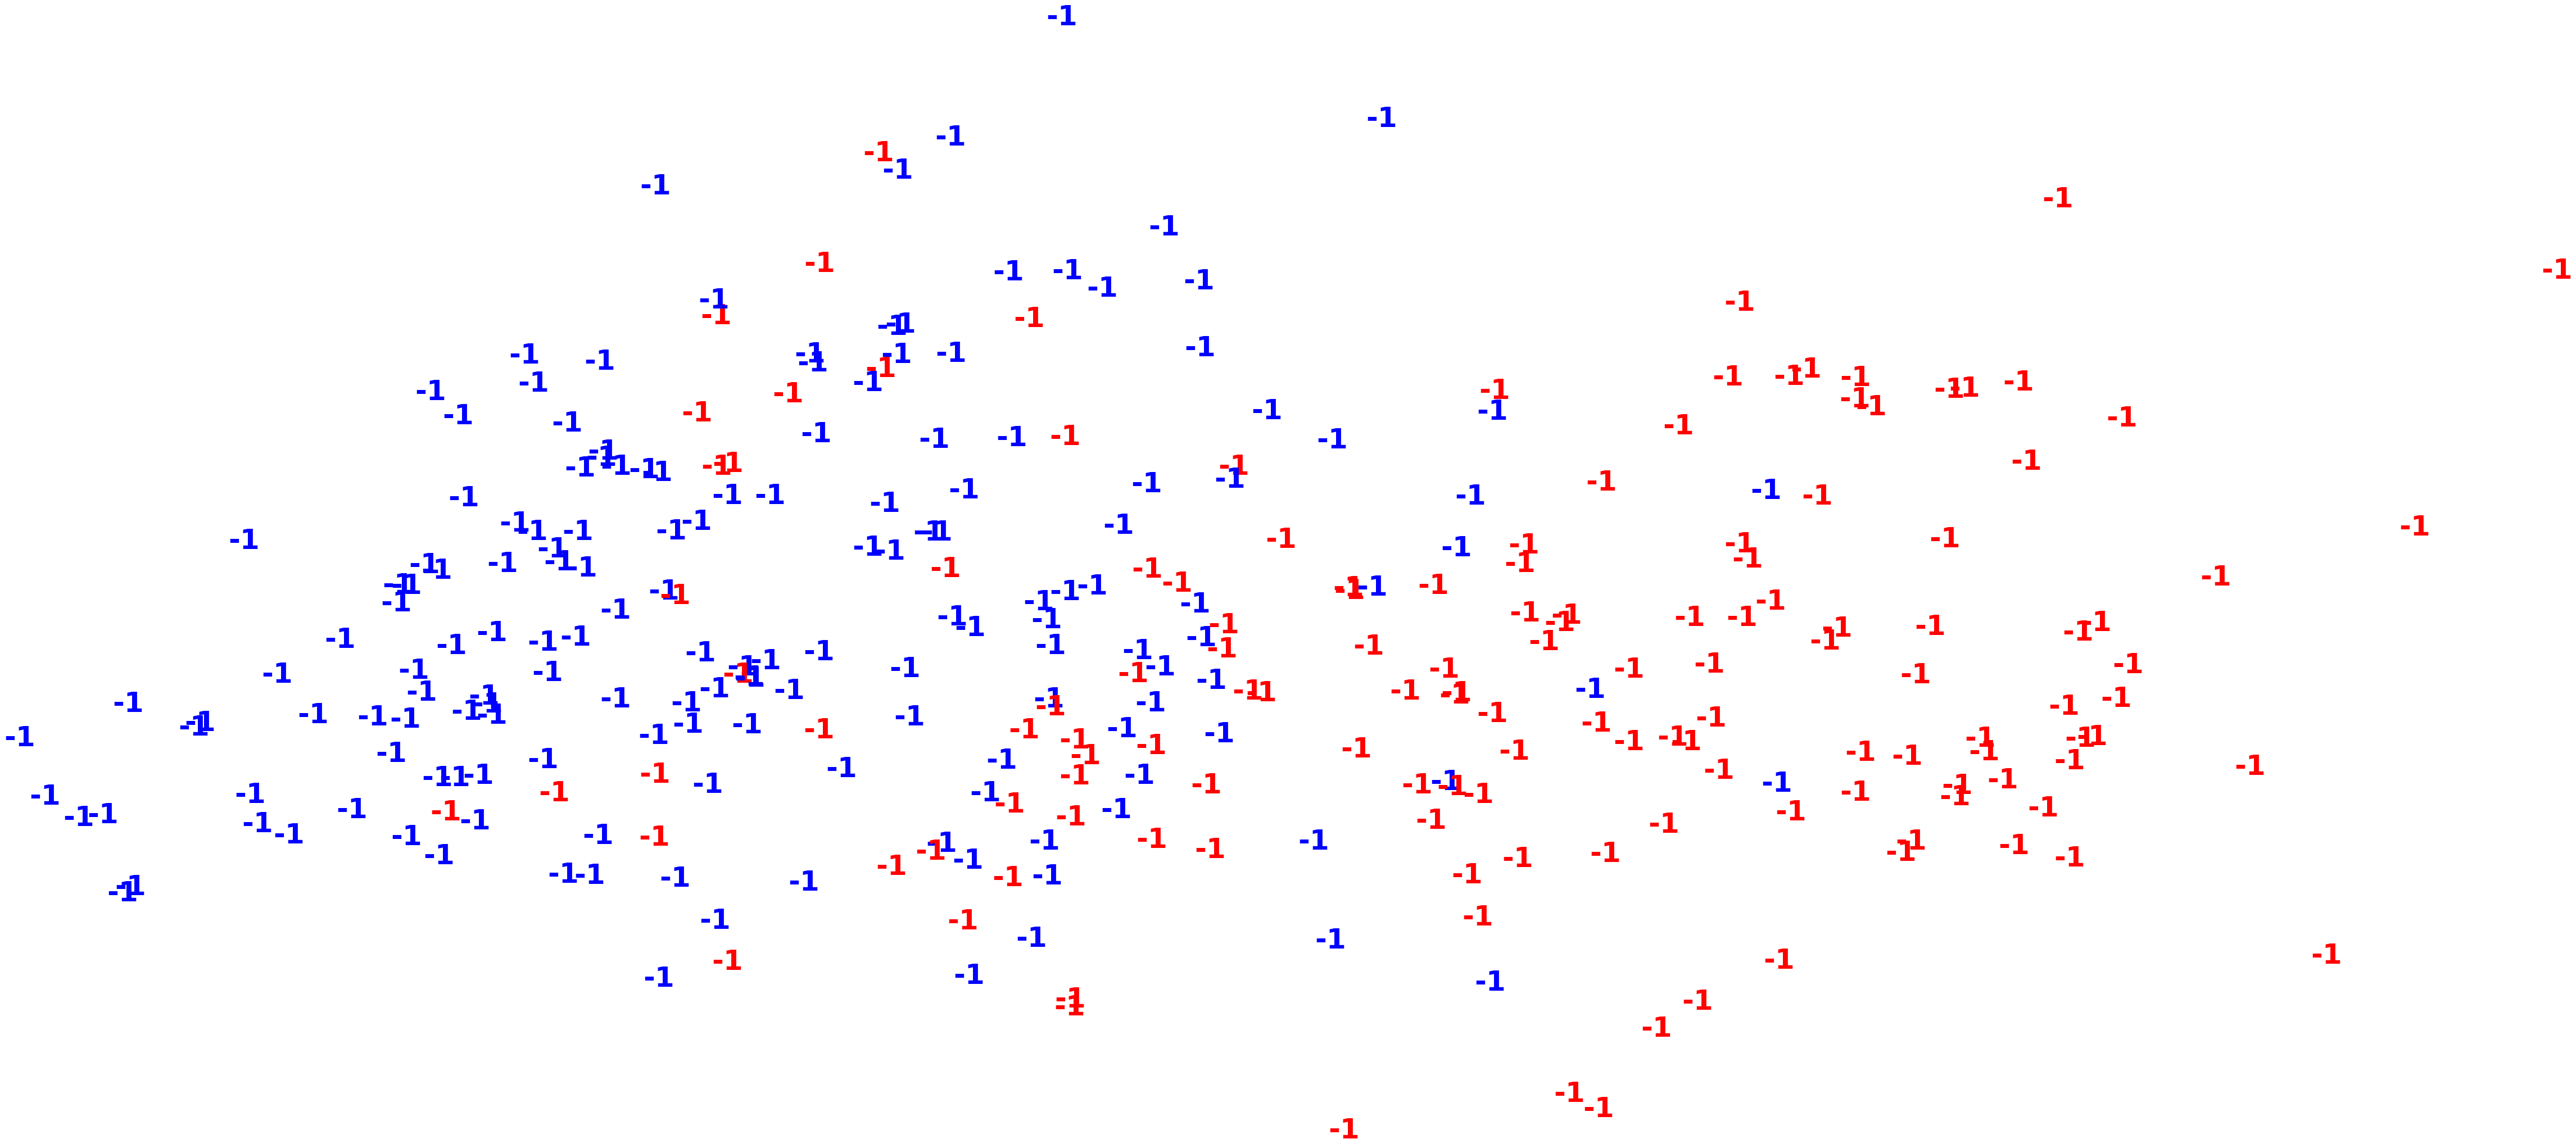

Adjusted Rand Index of the DBSCAN solution: 0.0


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [55]:
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=1, min_samples=4, metric='euclidean')

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)

pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()


print("Adjusted Rand Index of the DBSCAN solution: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

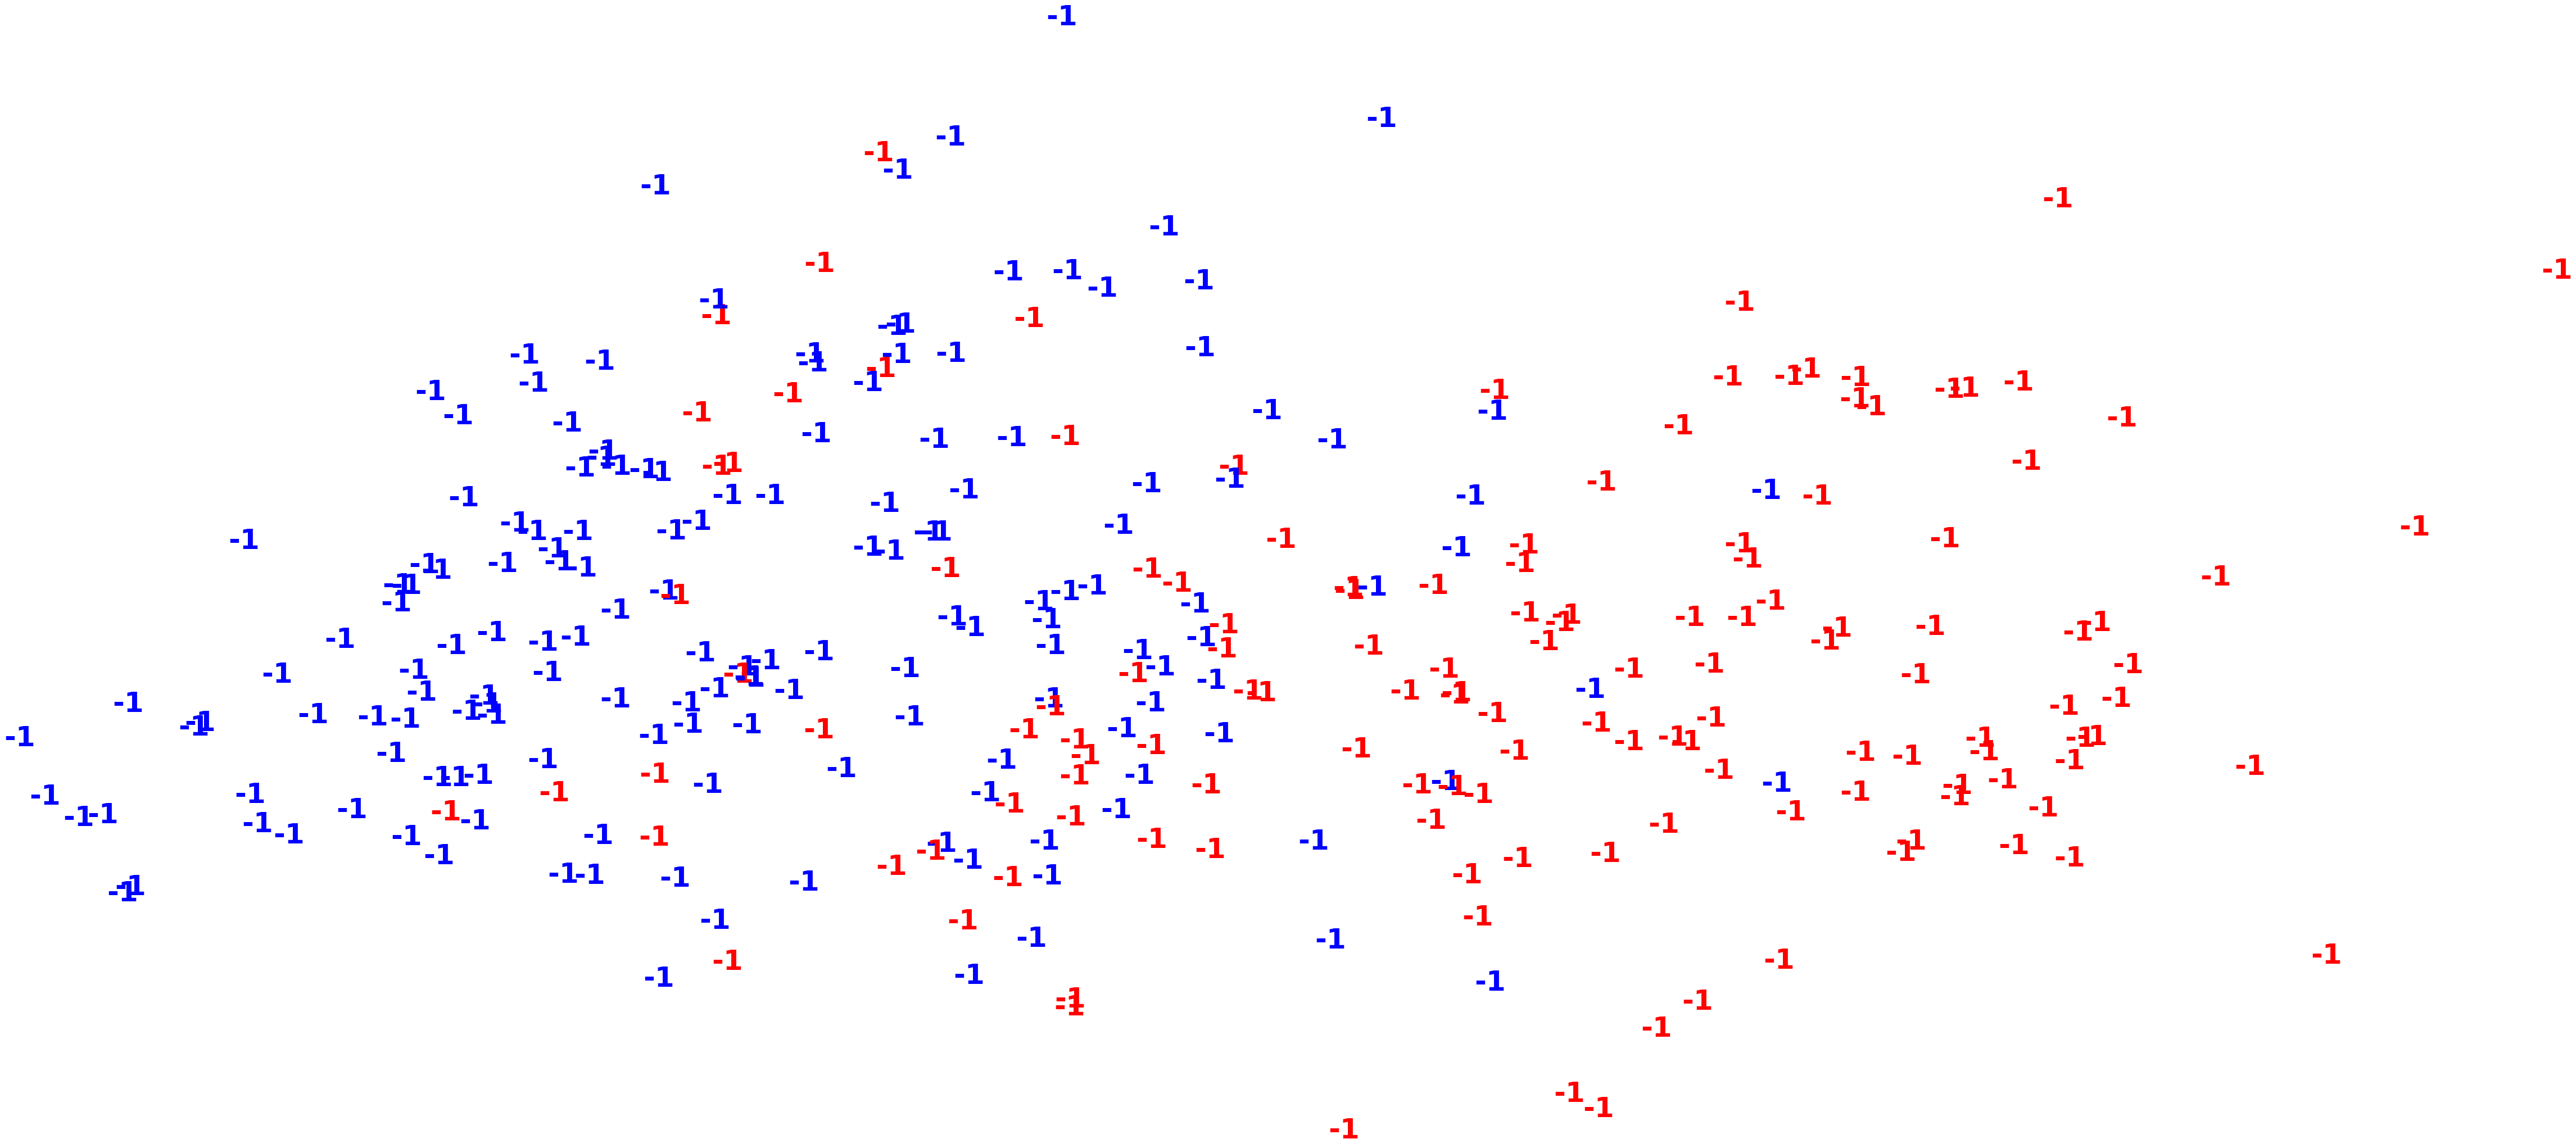

Adjusted Rand Index of the DBSCAN solution: 0.0


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [56]:
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=1, min_samples=6, metric='euclidean')

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)

pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()


print("Adjusted Rand Index of the DBSCAN solution: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

OBS:
- with only 1 min samples there were lots of clusters I can see, as the min samples increases lots of noises are shown.
- silhouette score couldn' be generated after min sample of 4, because of no samples.

3. Apply DBSCAN by setting parameters eps=1, min_samples=1, metric="euclidean". Then, increase the value of eps. What's the effect of increasing eps on the number of clusters DBSCAN identifies?

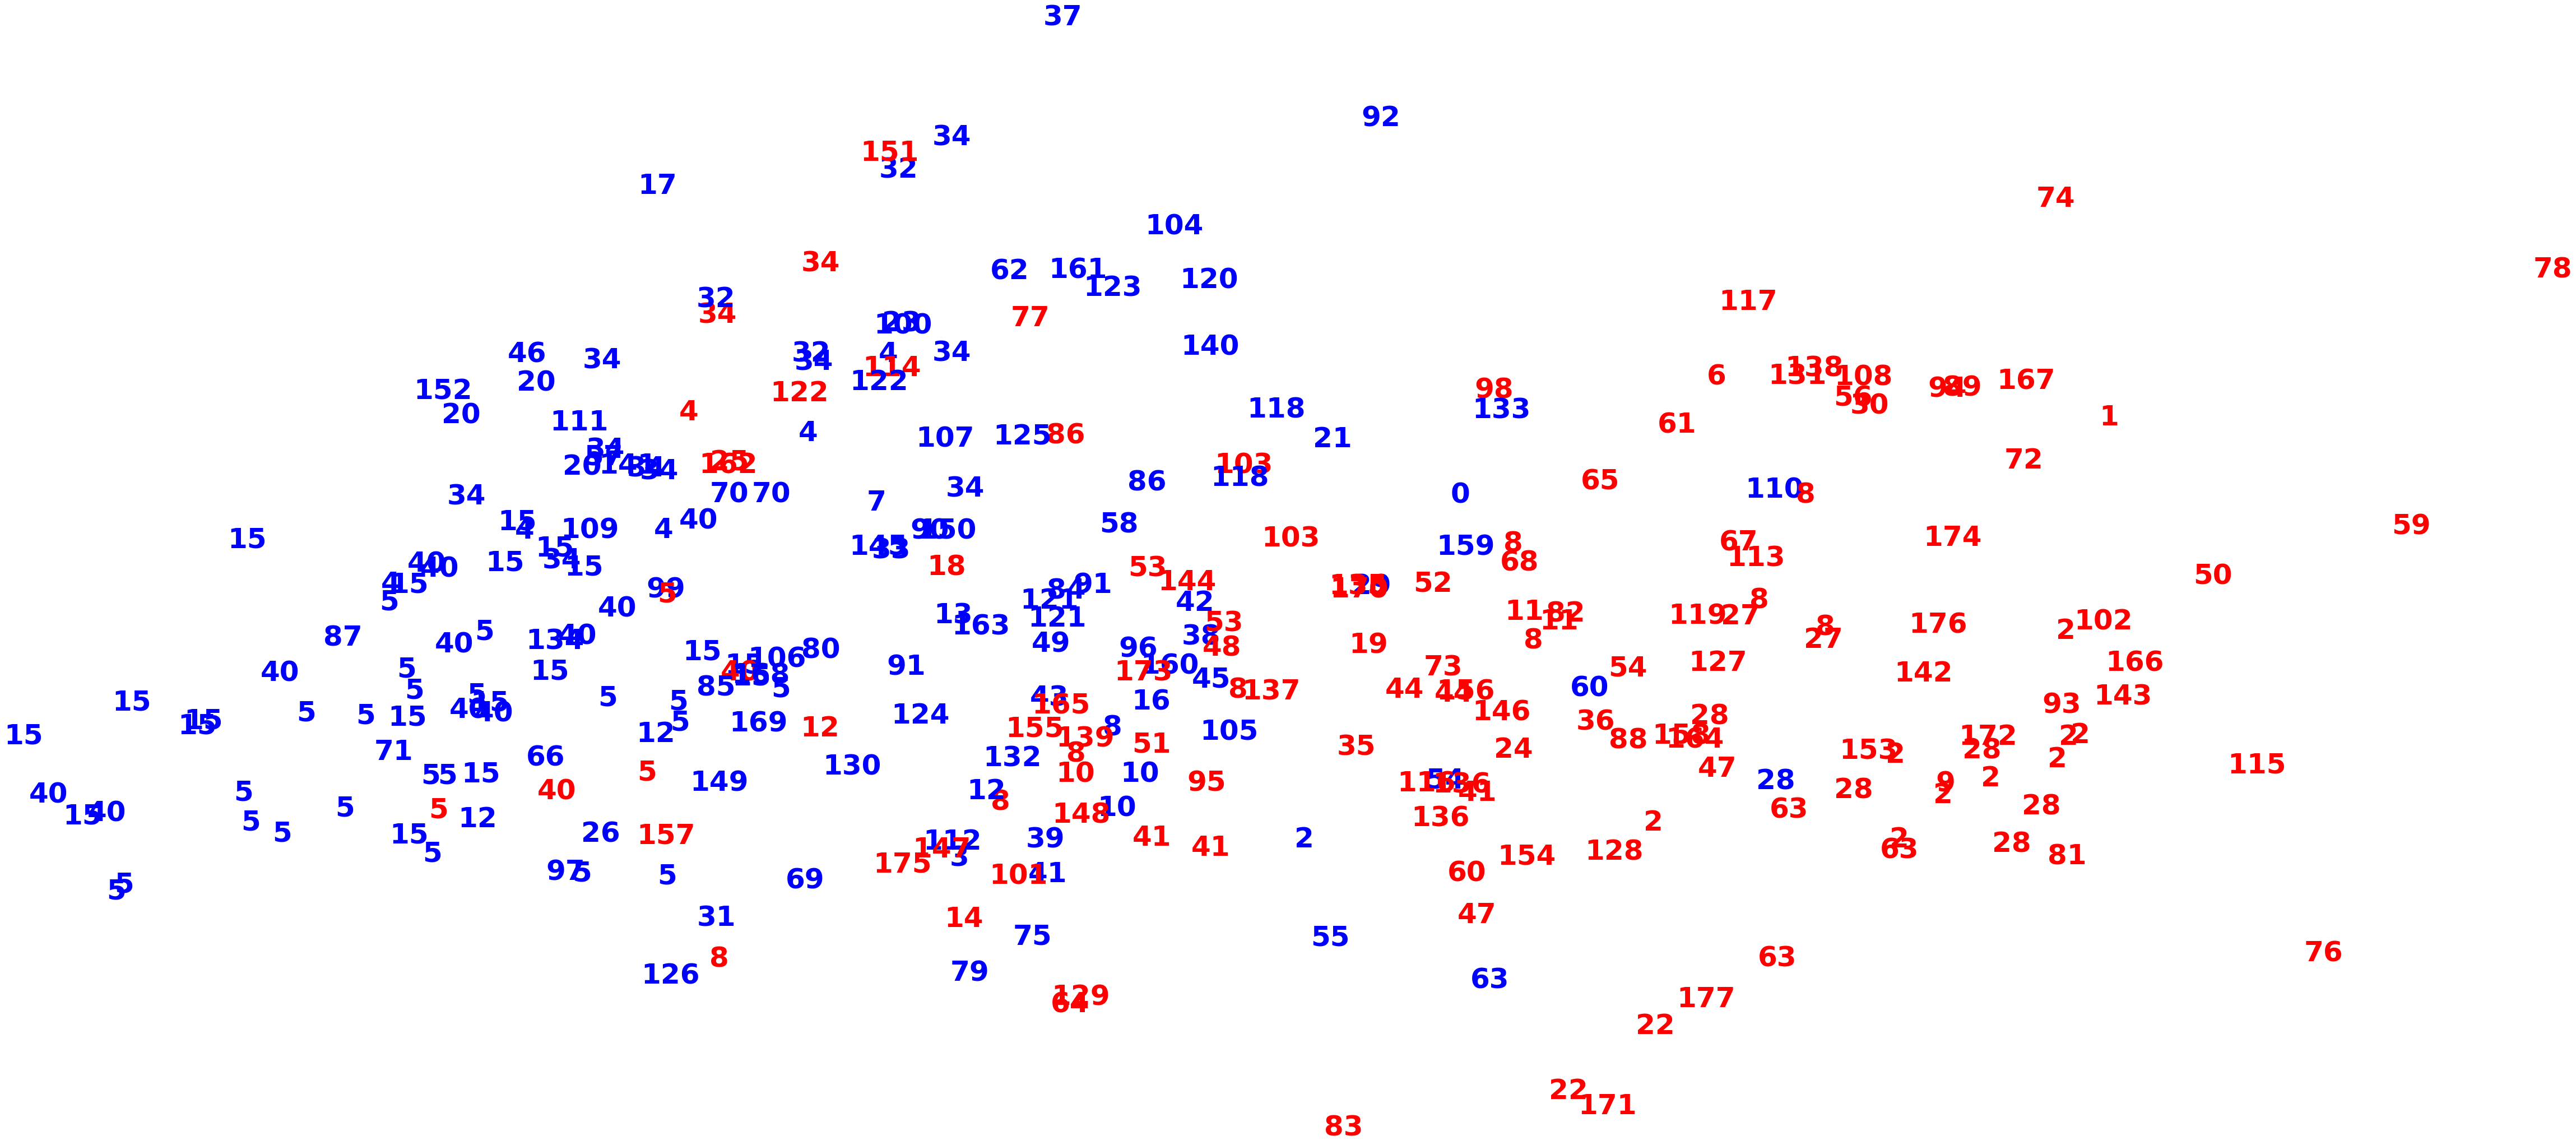

Adjusted Rand Index of the DBSCAN solution: 0.020781945262029176
The silhouette score of the DBSCAN solution: 0.0630865079970078


In [57]:
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=2, min_samples=1, metric='euclidean')

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)

pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()


print("Adjusted Rand Index of the DBSCAN solution: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

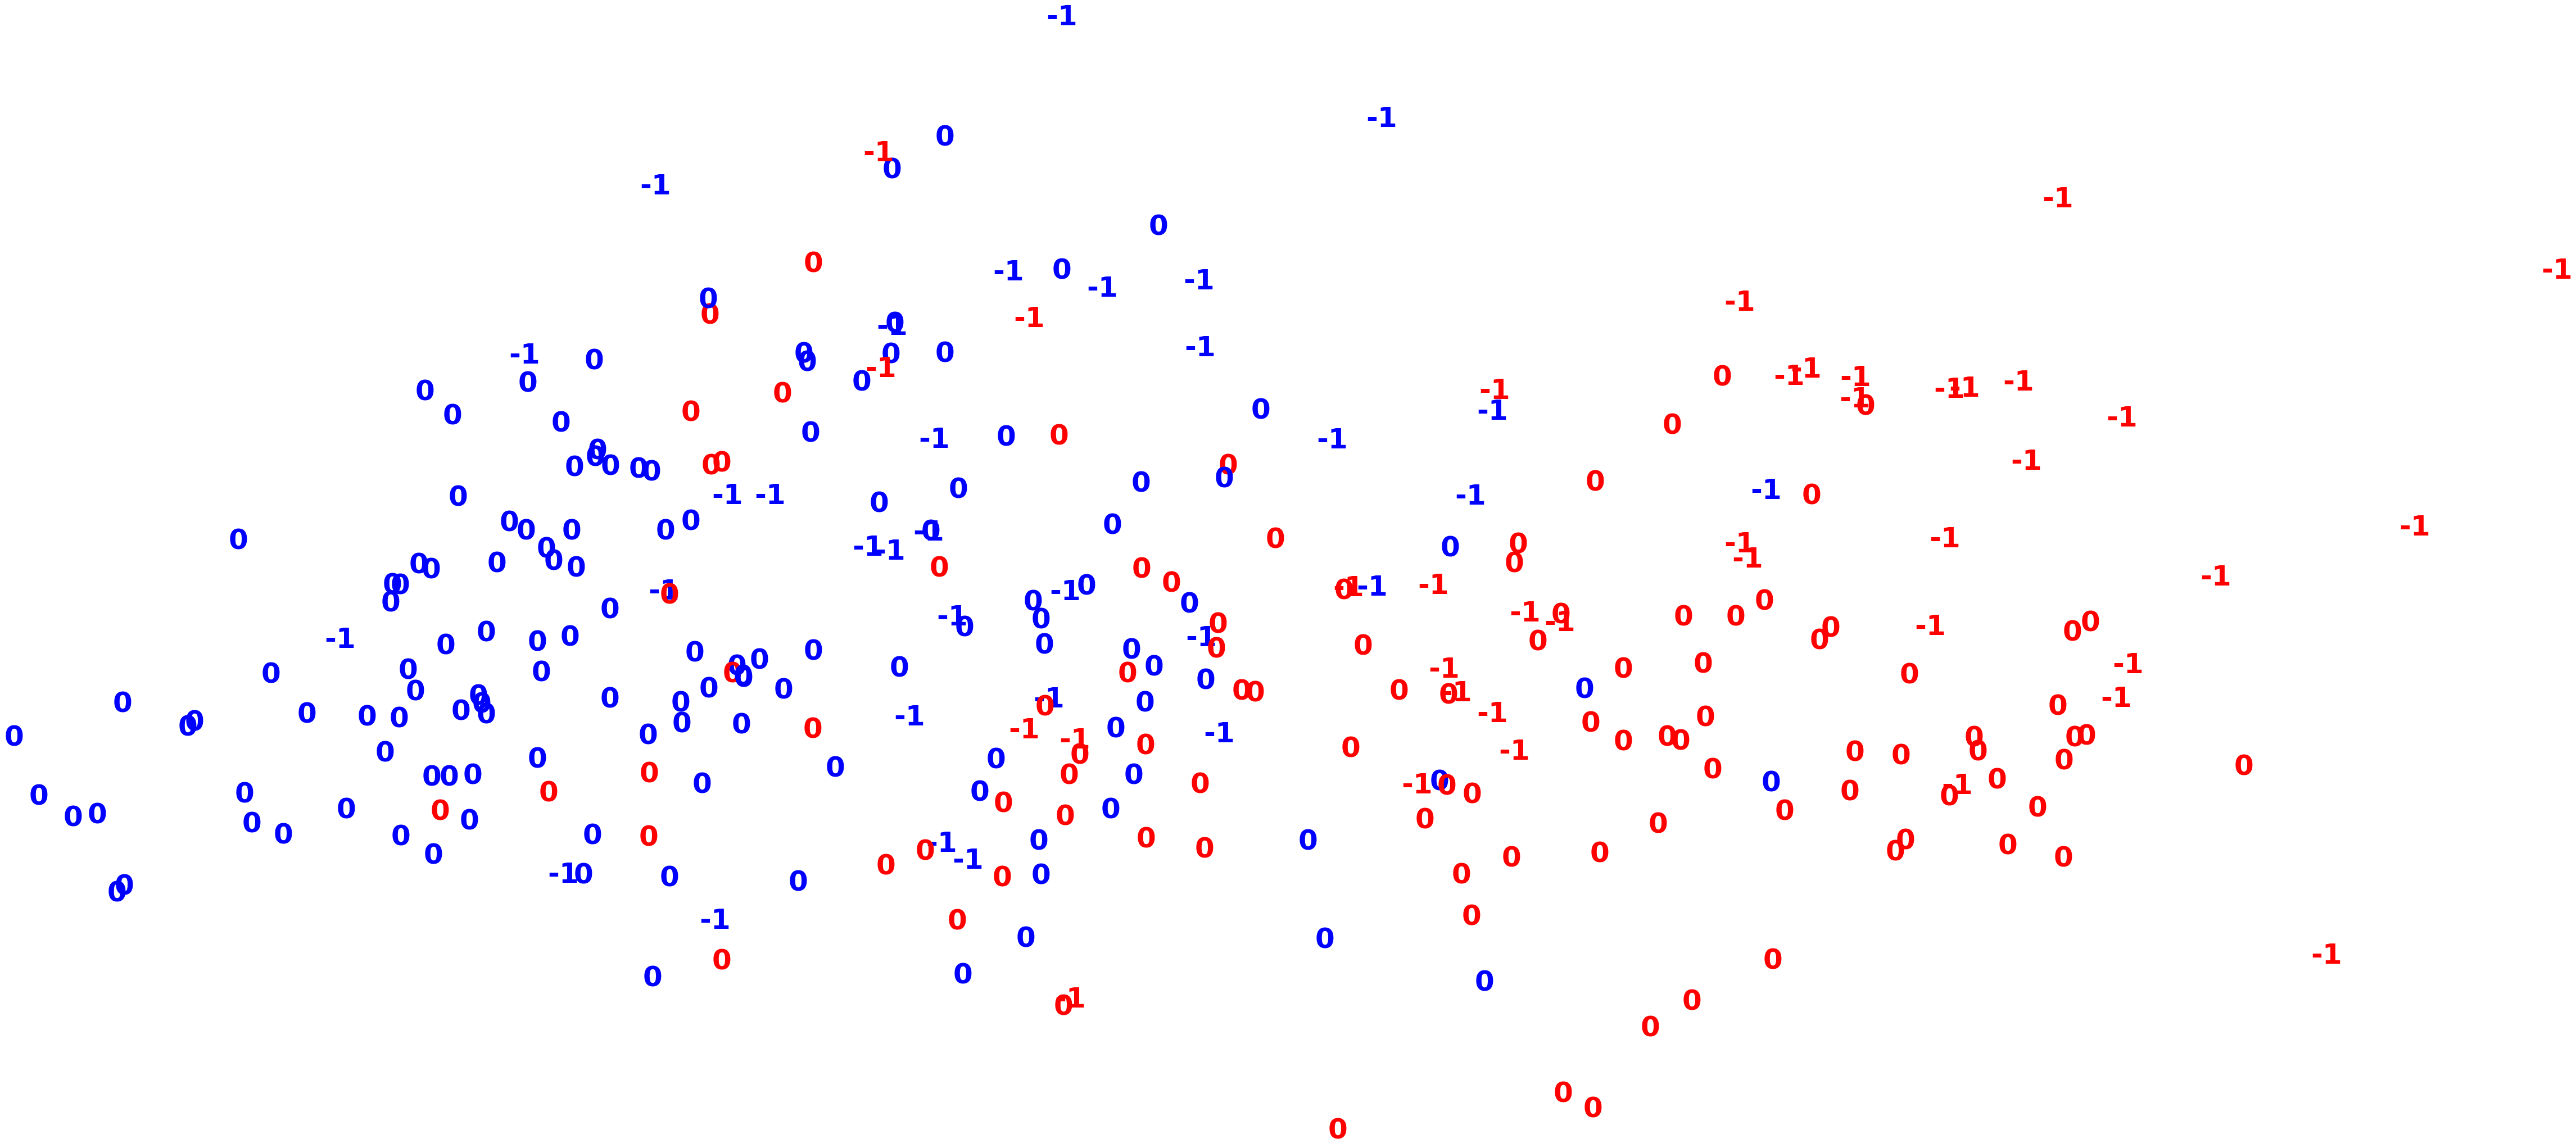

Adjusted Rand Index of the DBSCAN solution: 0.010083311480551273
The silhouette score of the DBSCAN solution: 0.14752033983595578


In [58]:
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=3, min_samples=6, metric='euclidean')

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)

pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()


print("Adjusted Rand Index of the DBSCAN solution: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

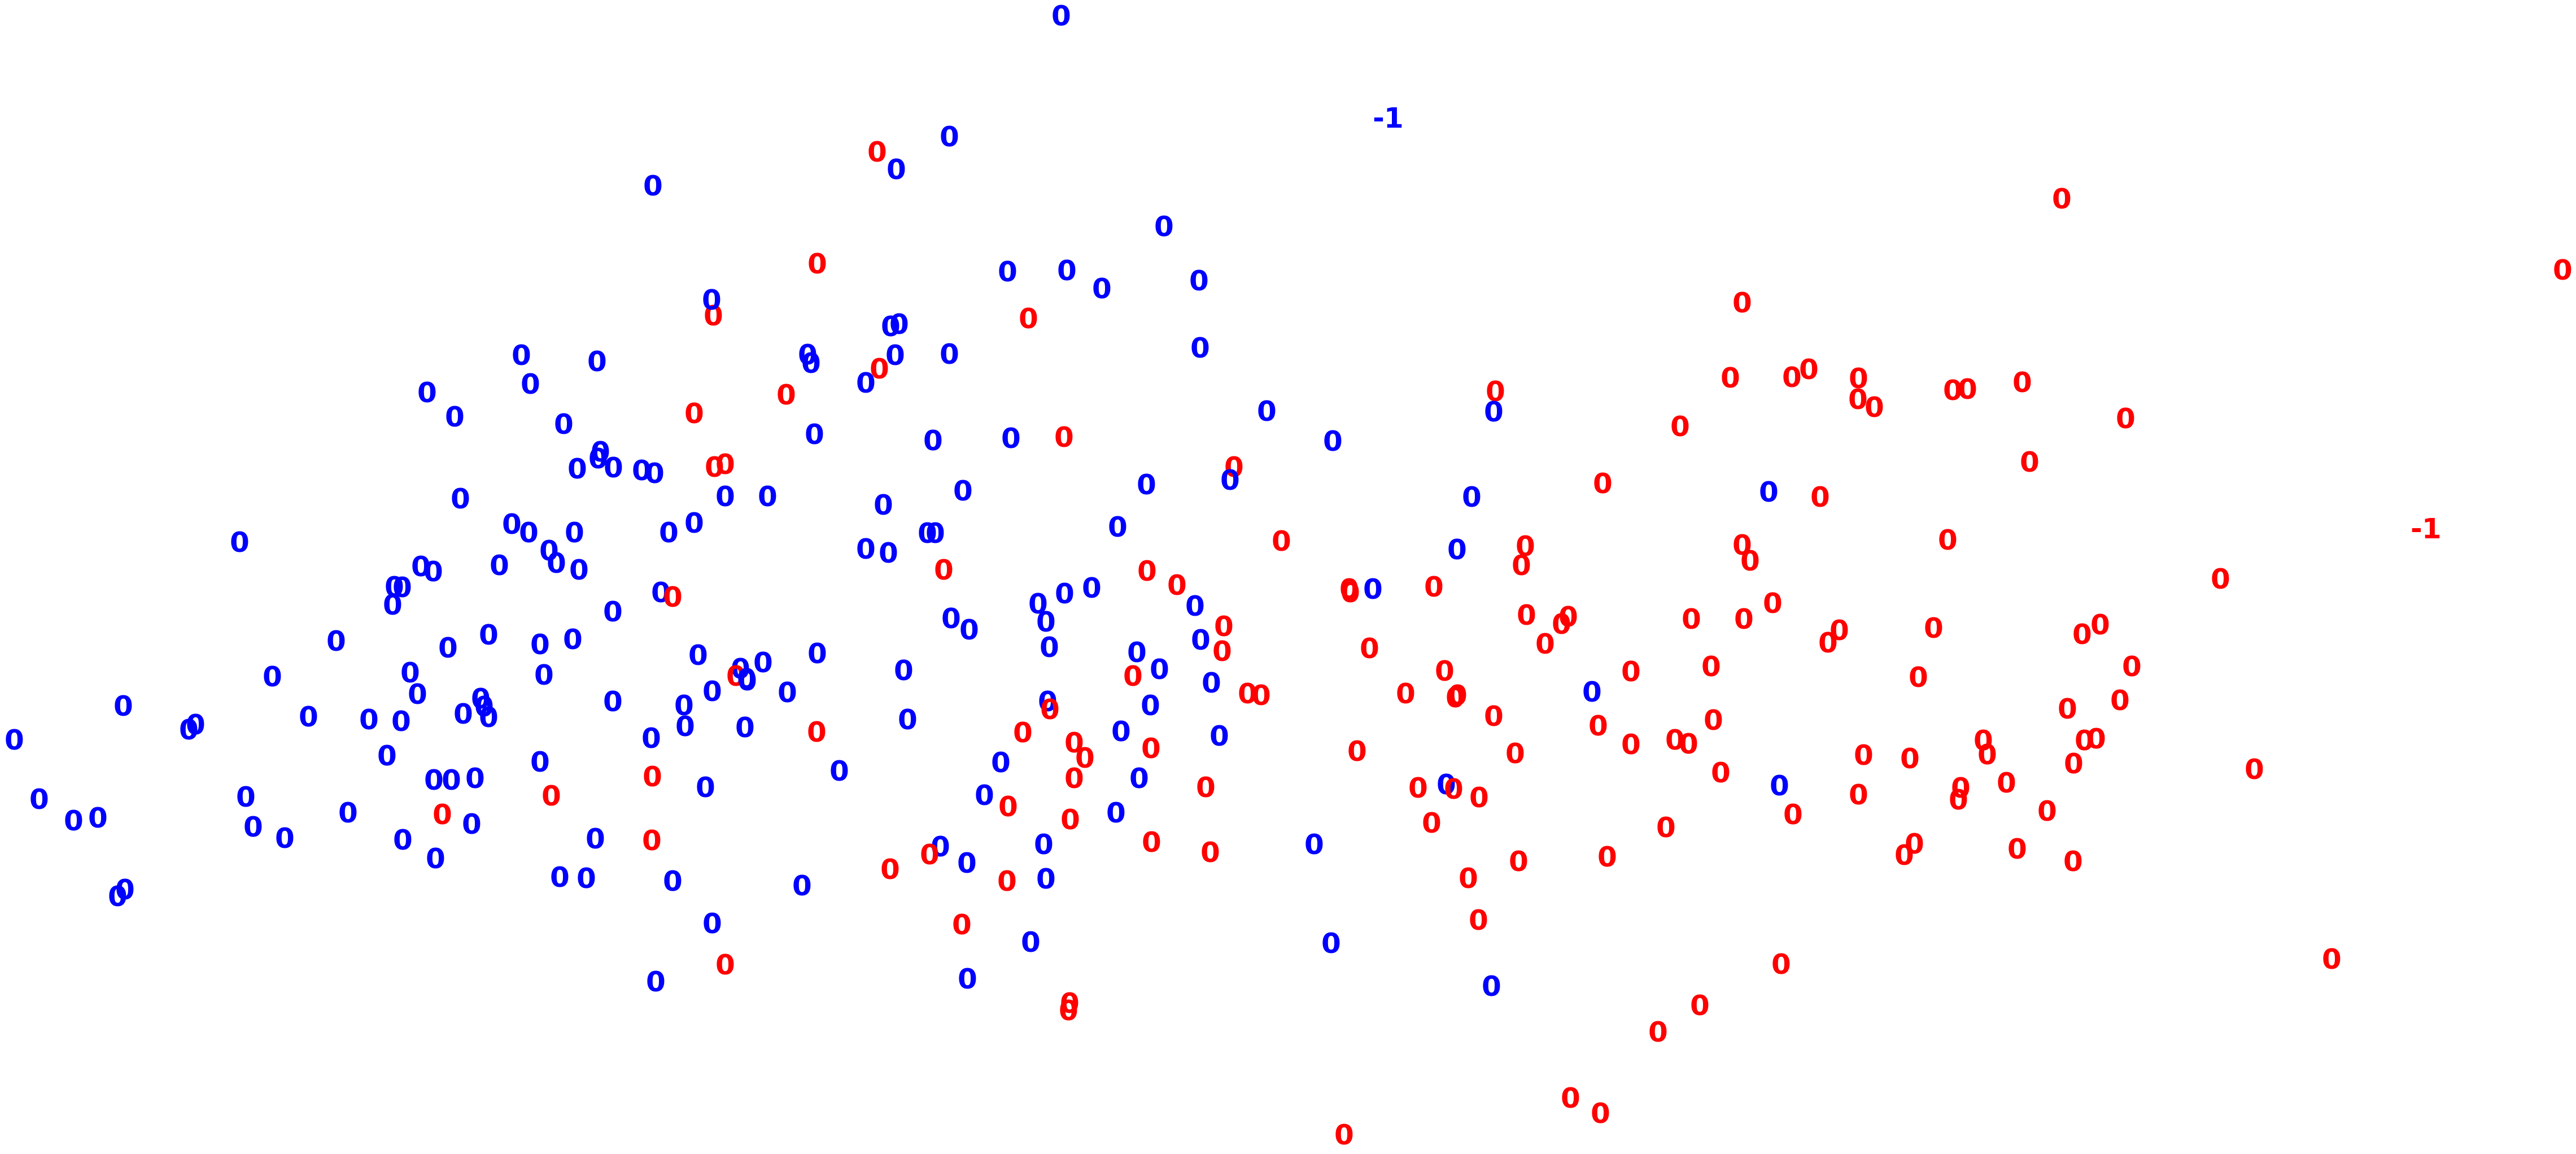

Adjusted Rand Index of the DBSCAN solution: 7.981624730729779e-05
The silhouette score of the DBSCAN solution: 0.33675285916660913


In [59]:
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=4, min_samples=6, metric='euclidean')

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)

pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()


print("Adjusted Rand Index of the DBSCAN solution: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

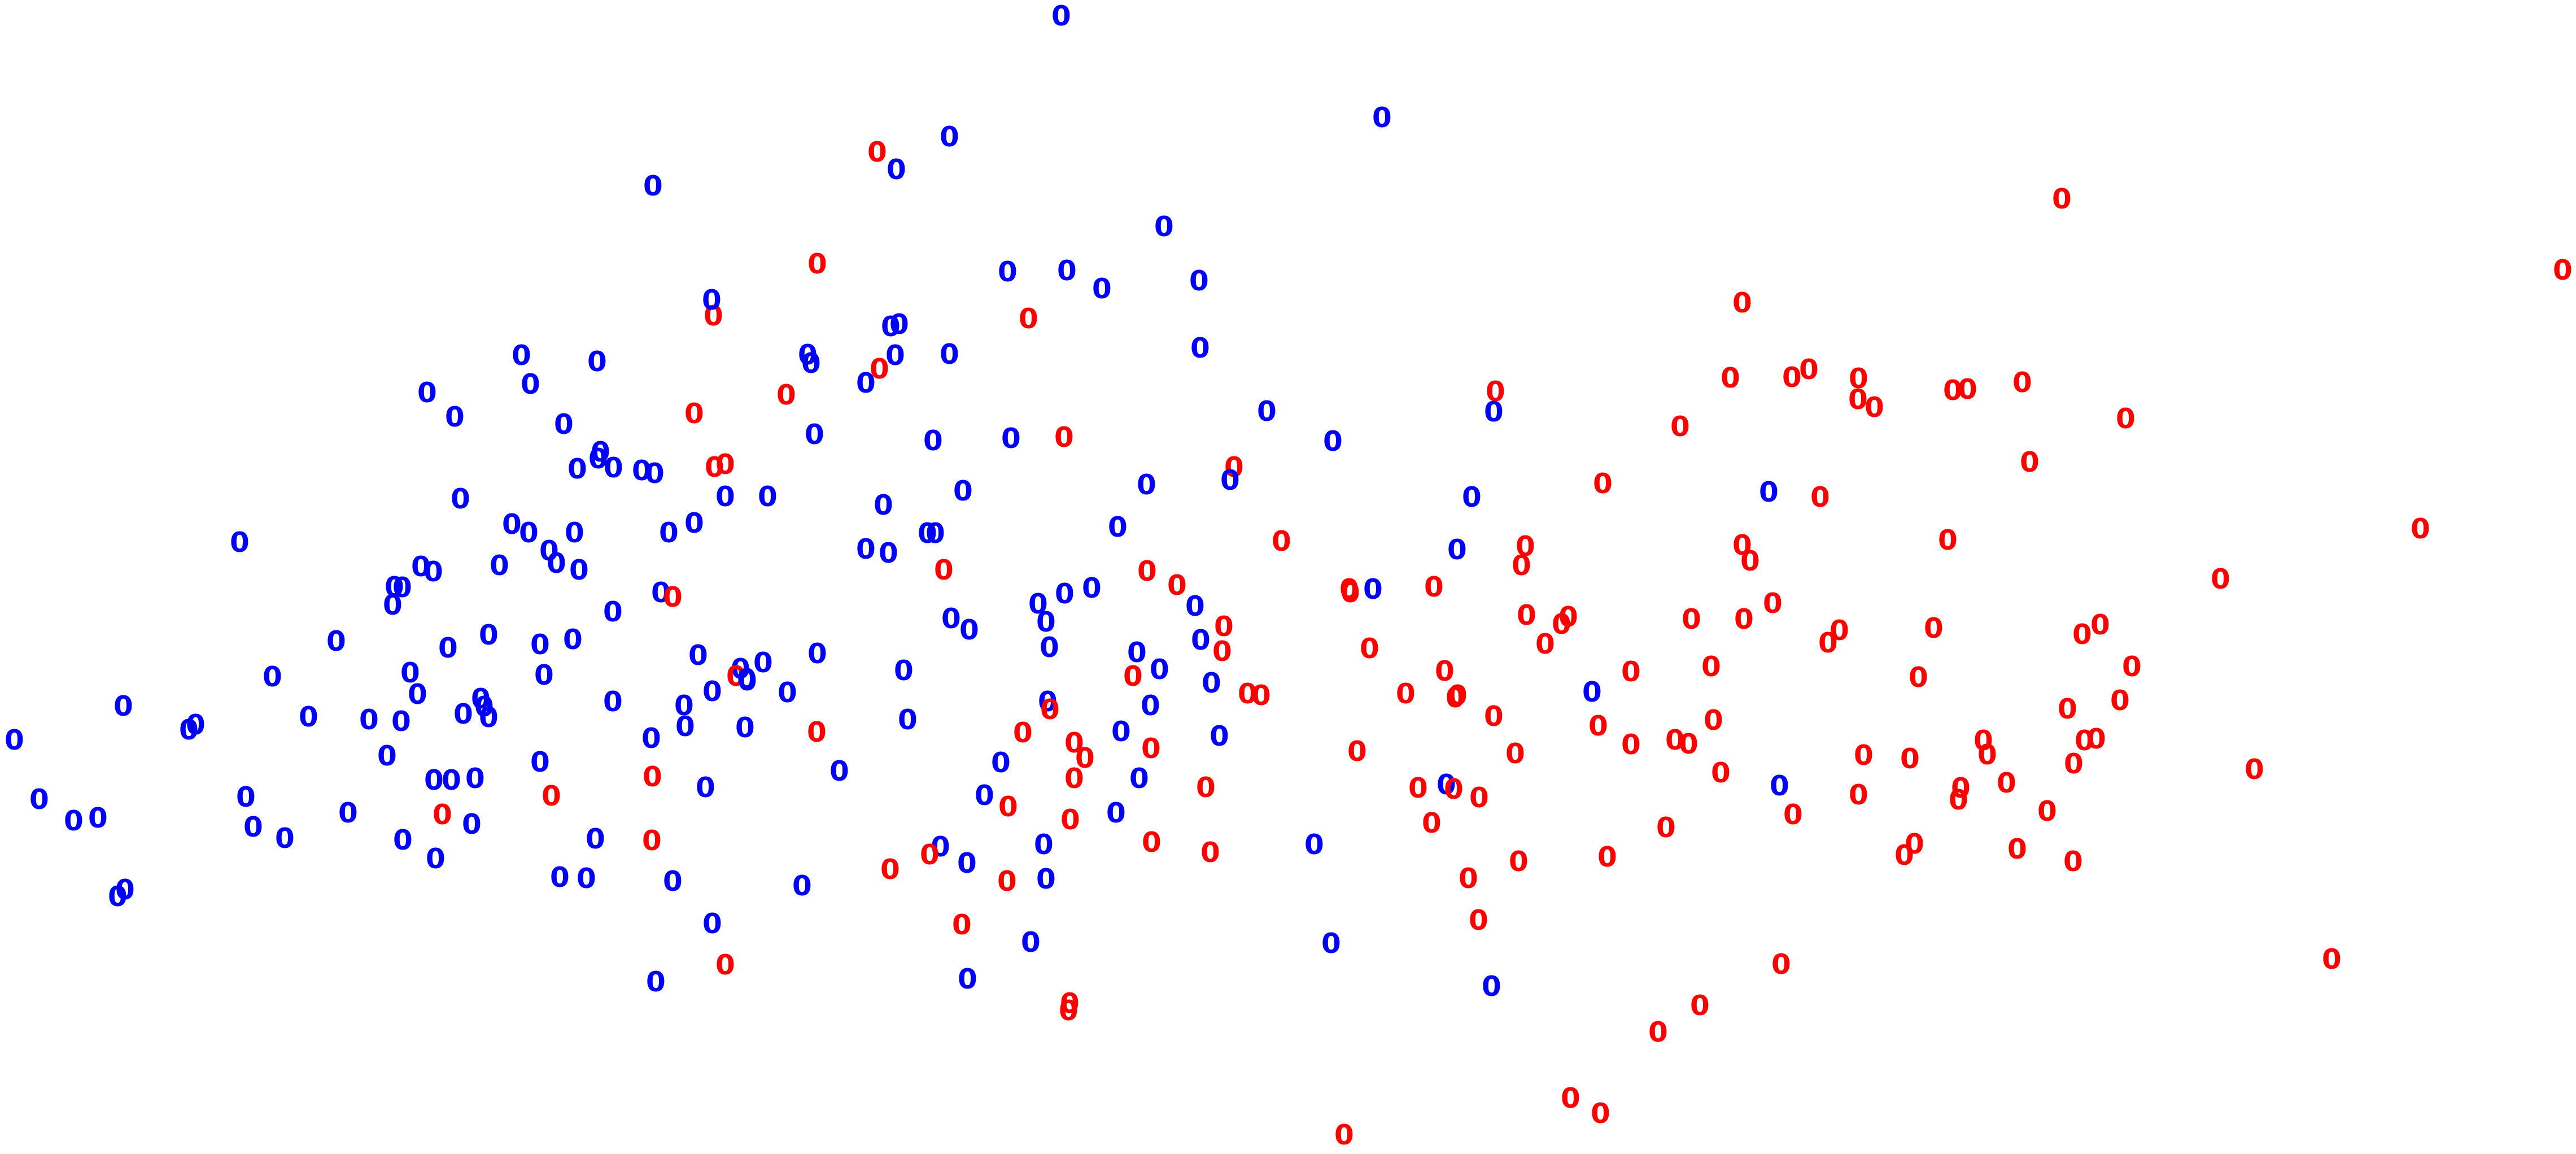

Adjusted Rand Index of the DBSCAN solution: 0.0


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [60]:
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=5, min_samples=6, metric='euclidean')

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)

pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()


print("Adjusted Rand Index of the DBSCAN solution: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

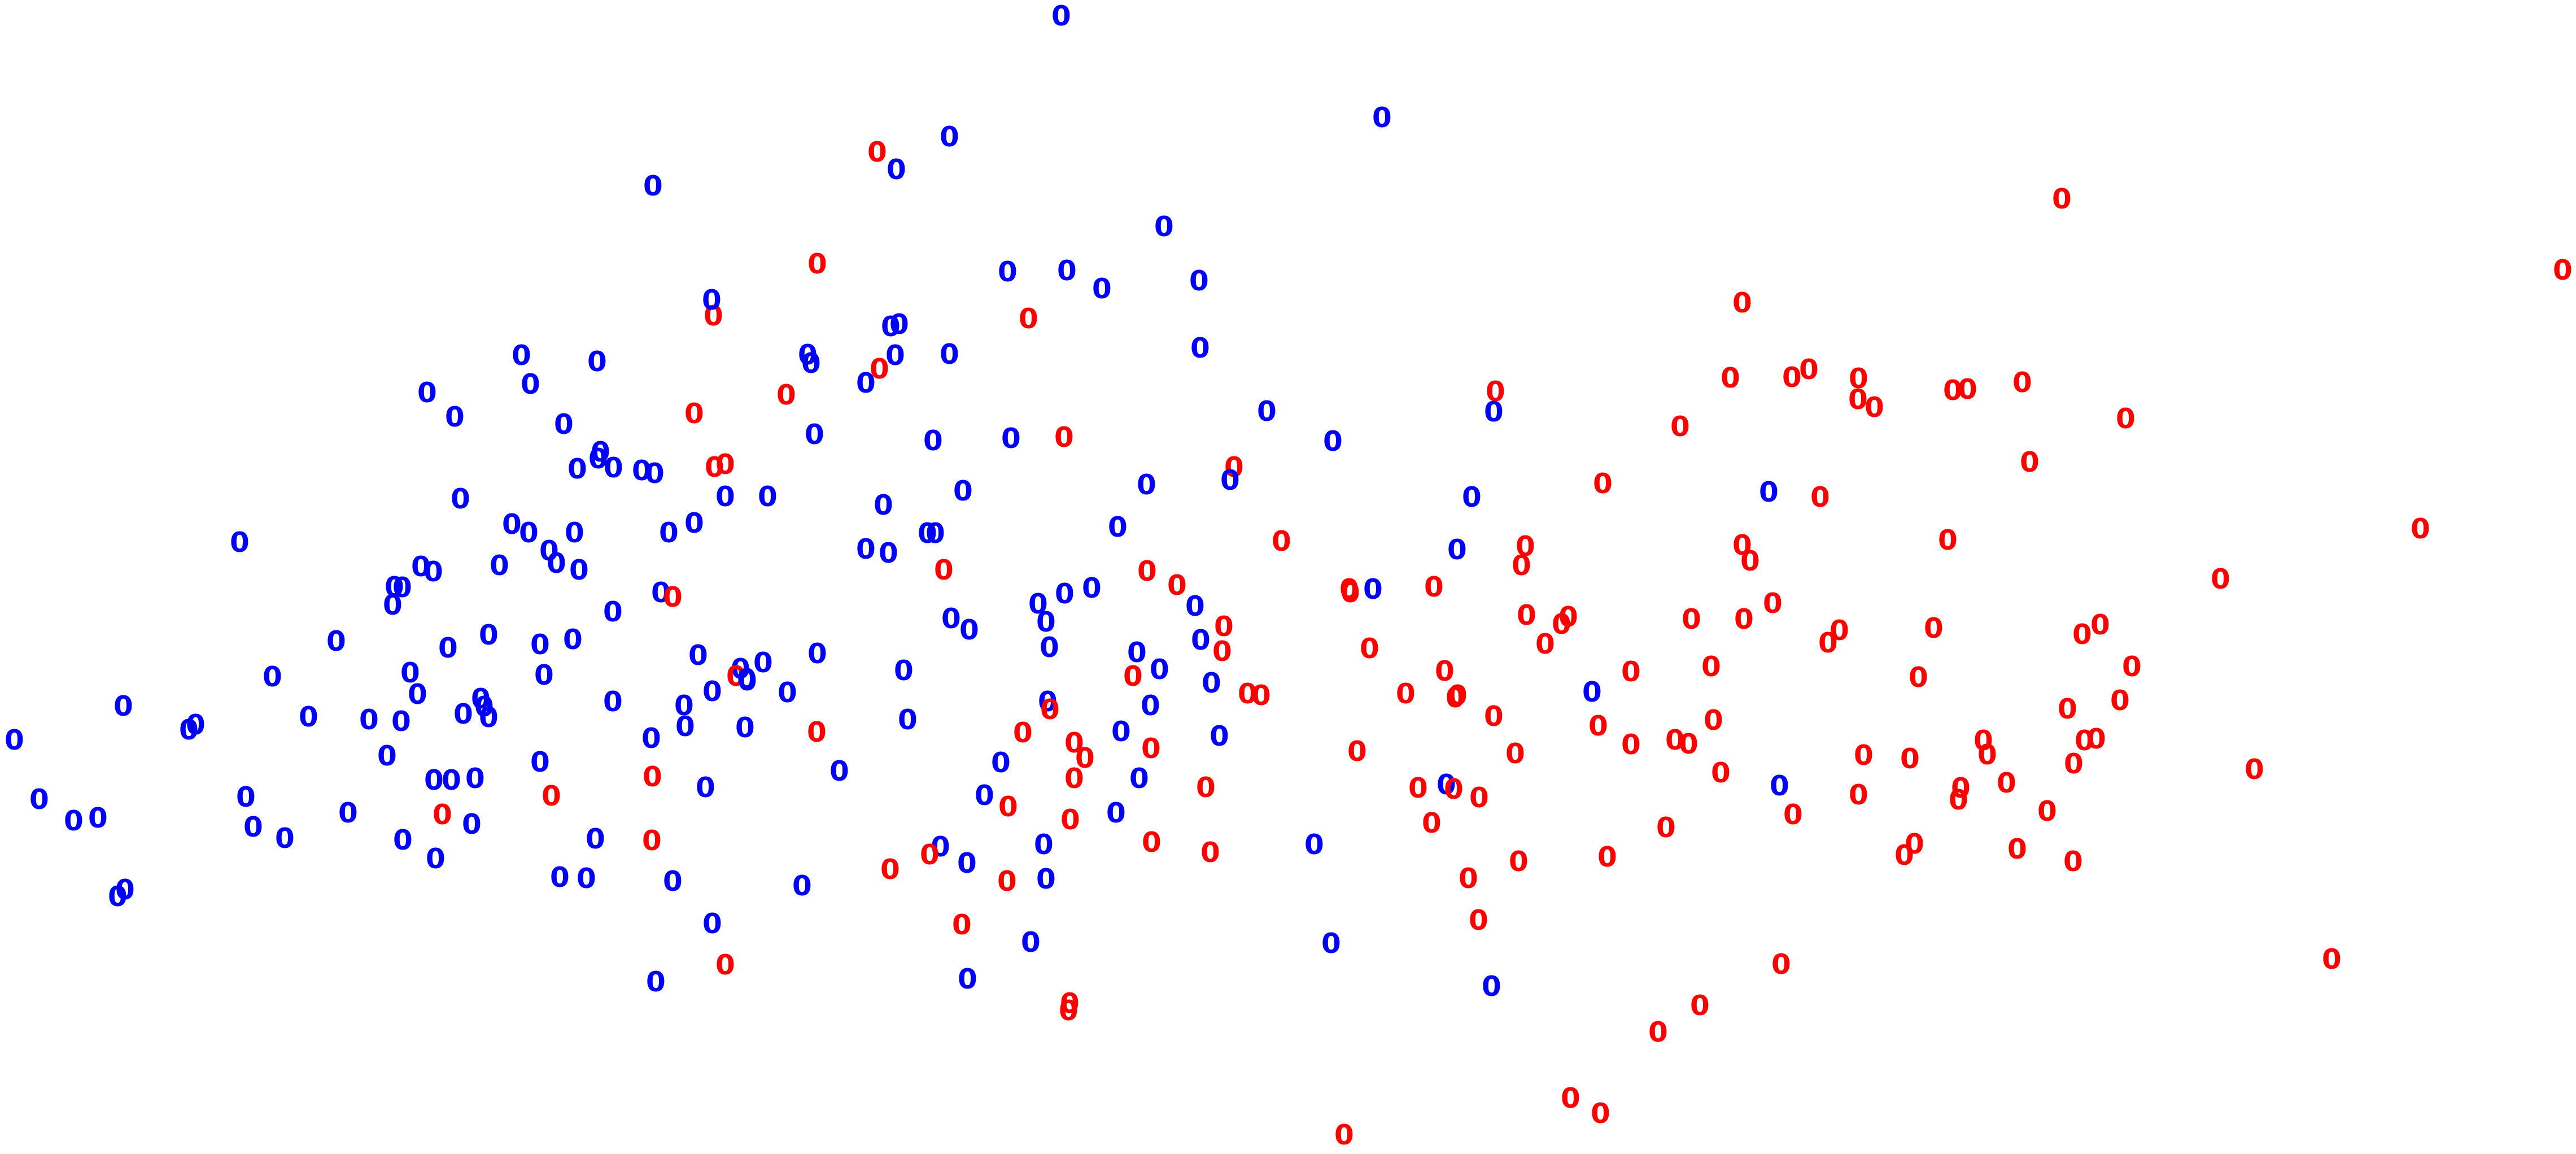

Adjusted Rand Index of the DBSCAN solution: 0.0


ValueError: Number of labels is 1. Valid values are 2 to n_samples - 1 (inclusive)

In [61]:
# Defining the agglomerative clustering
dbscan_cluster = DBSCAN(eps=6, min_samples=6, metric='euclidean')

# Fit model
clusters = dbscan_cluster.fit_predict(X_std)

pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()


print("Adjusted Rand Index of the DBSCAN solution: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhouette score of the DBSCAN solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

OBS:
- as eps the radius is increases, only one cluster is found.

## Assignment 5:

1. Apply GMM to the heart disease data by setting n_components=2. Get ARI and silhoutte scores for your solution and compare it with those of the k-means and hierarchical clustering solutions that you implemented in the assignments of the previous checkpoints. Which algorithm does perform better?

2. GMM implementation of scikit-learn has a parameter called covariance_type. This parameter determines the type of covariance parameters to use. Specifically, there are four types you can specify:

    - full: This is the default. Each component has its own general covariance matrix.
    - tied: All components share the same general covariance matrix.
    - diag: Each component has its own diagonal covariance matrix.
    - spherical: Each component has its own single variance.
- Try all of these. Which one does perform better in terms of ARI and silhouette scores?

In [66]:
from matplotlib.patches import Ellipse
from sklearn.mixture import GaussianMixture

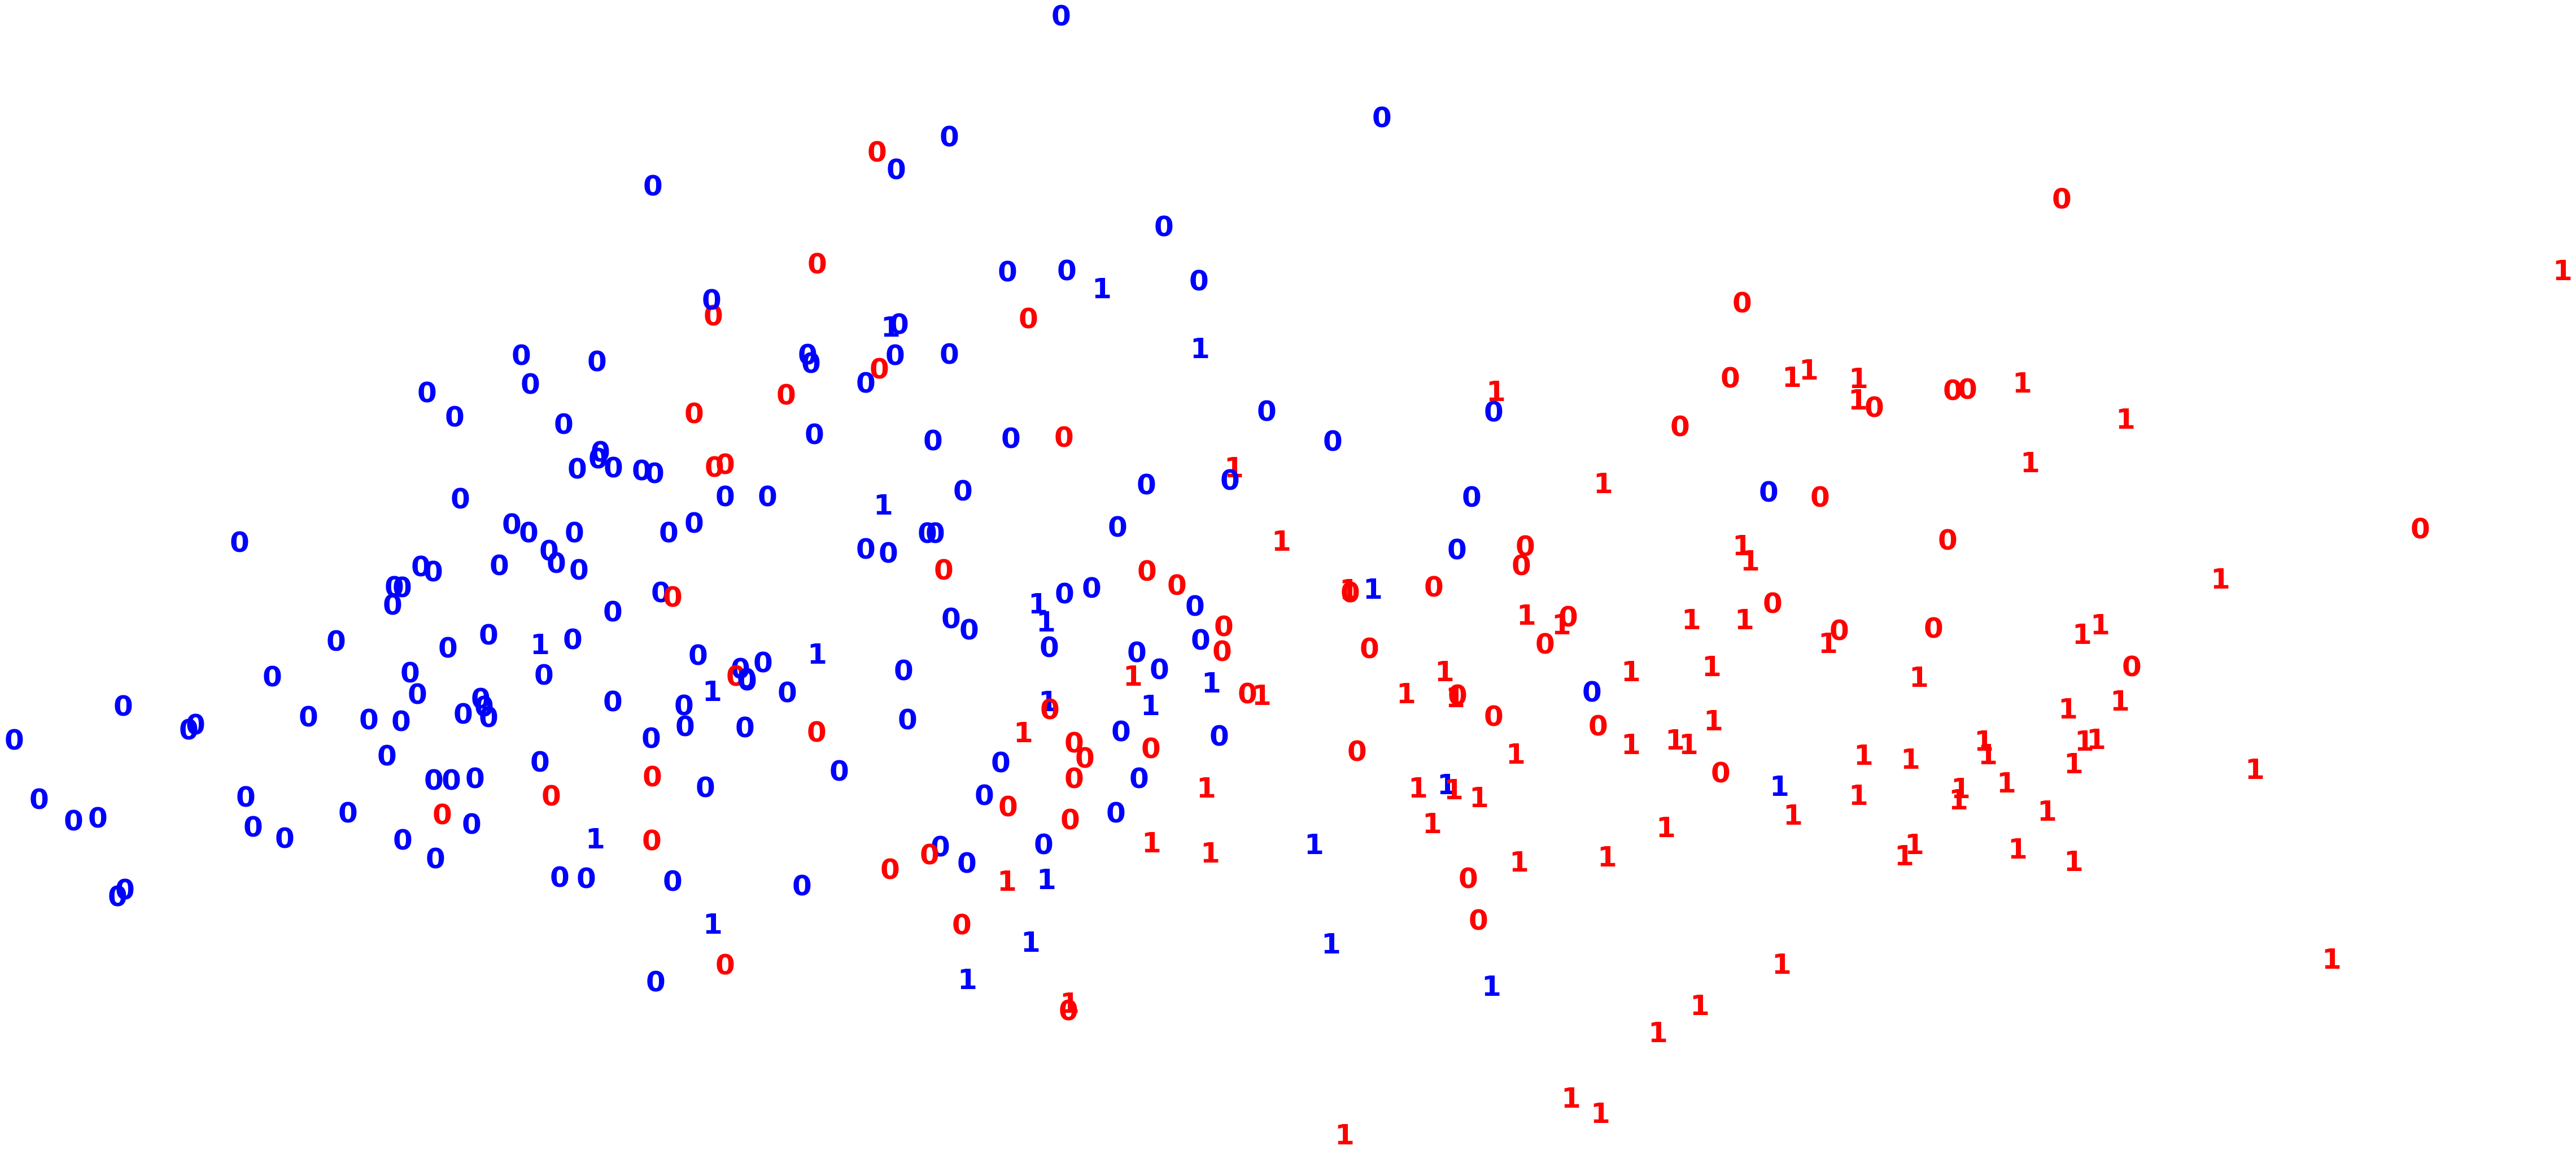

Adjusted Rand Index of the GMM solution: 0.18230716541111341
The silhoutte score of the GMM solution: 0.13560123273712887


In [67]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=2, random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

print("Adjusted Rand Index of the GMM solution: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhoutte score of the GMM solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

In [68]:
pd.crosstab(y,clusters)

col_0    0   1
row_0         
0       63  76
1      140  23

Obs:
- K means = 2, gives higher ARI of 0.44 and silhoutte score of 0.17
- Hierchial, using average linkage we got ARI of 0.29 and silhoutte score of 0.14
             using ward linkage we got ARI of 0.14 and silhoutte score of 0.13
- GMM with n_components of 2, gives us ARI of 0.18 and silhoutte score of 0.13

- looking at all clustering method, K means got higher ARI and silhoutte score, which means its a netter model.

2.

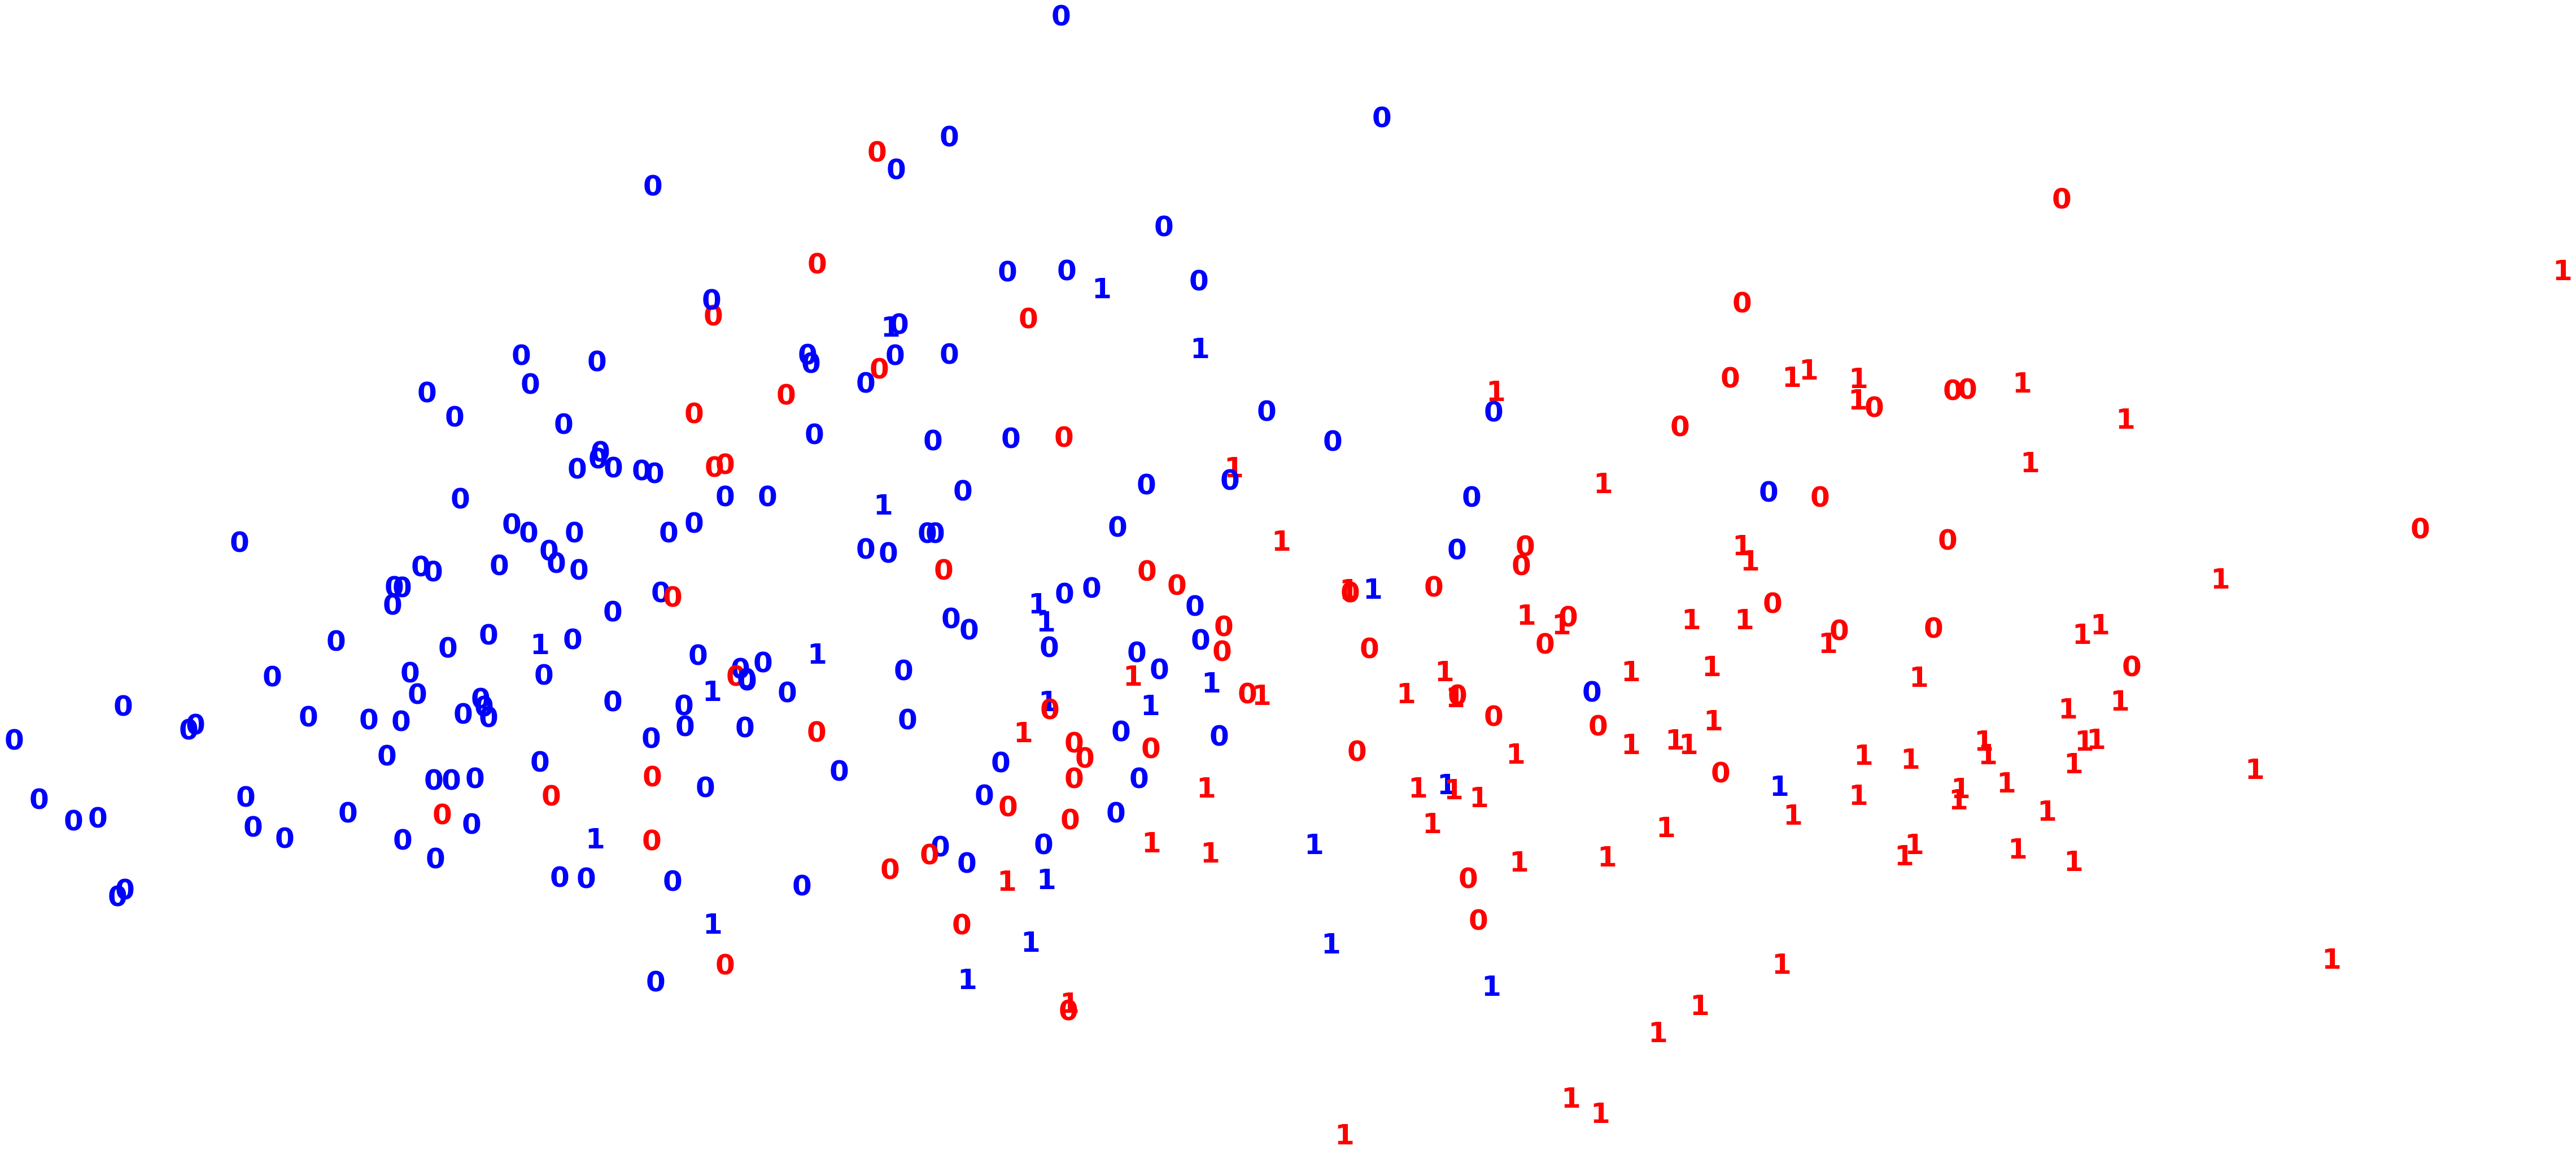

Adjusted Rand Index of the GMM solution: 0.18230716541111341
The silhoutte score of the GMM solution: 0.13560123273712887


In [74]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=2, covariance_type='tied', random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

print("Adjusted Rand Index of the GMM solution: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhoutte score of the GMM solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

In [75]:
pd.crosstab(y,clusters)

col_0    0   1
row_0         
0       63  76
1      140  23

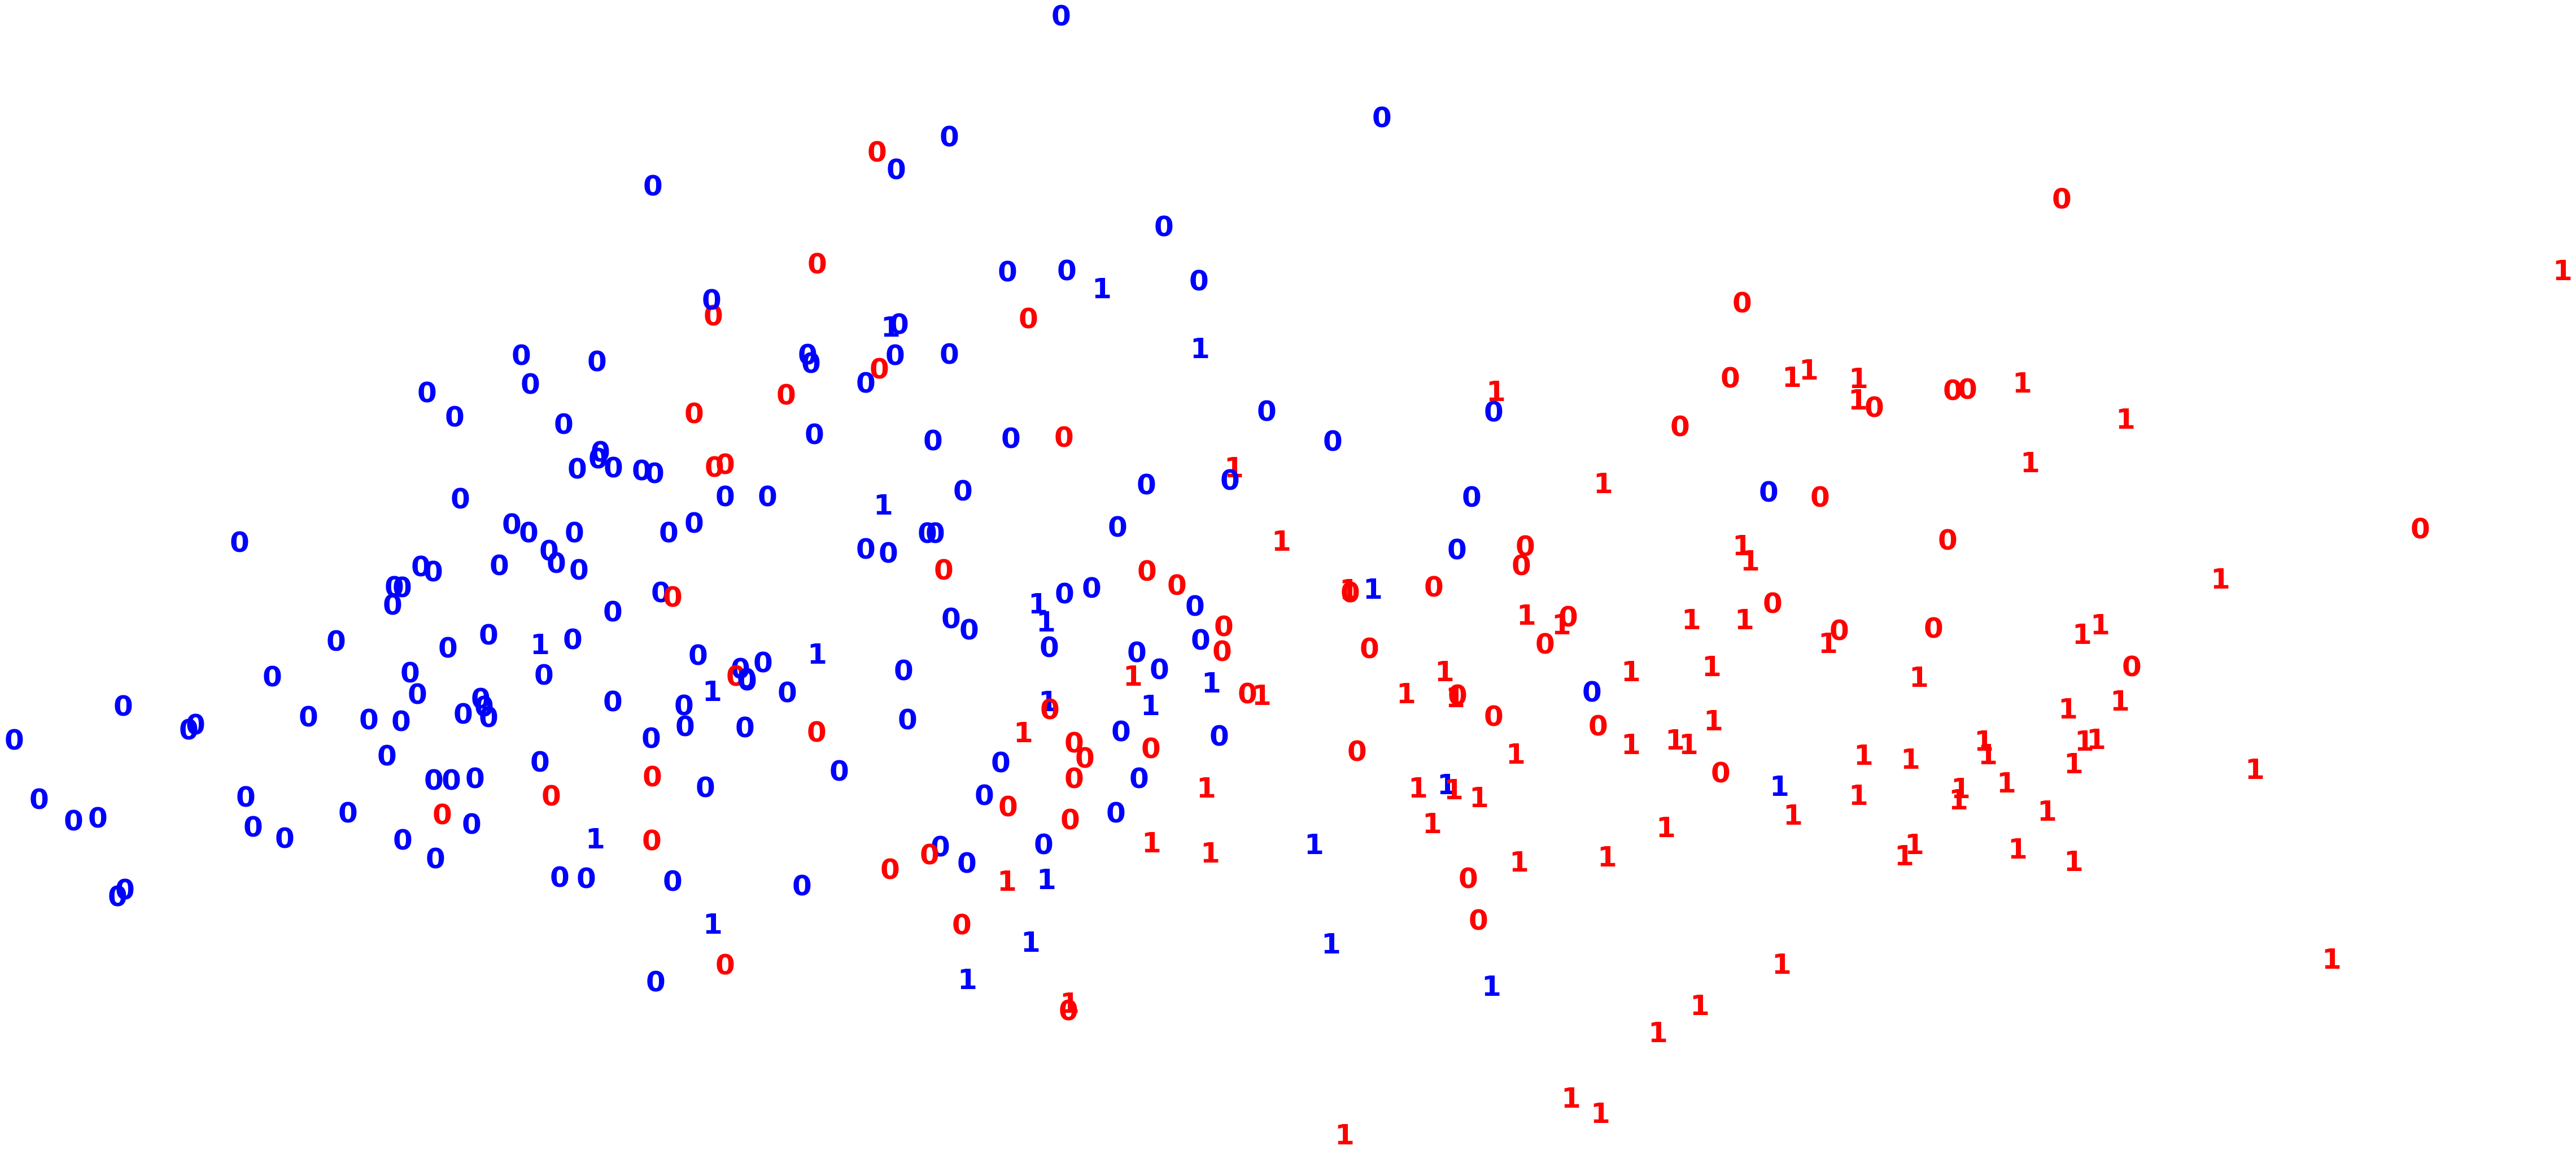

Adjusted Rand Index of the GMM solution: 0.18230716541111341
The silhoutte score of the GMM solution: 0.13560123273712887


In [76]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=2, covariance_type='diag', random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

print("Adjusted Rand Index of the GMM solution: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhoutte score of the GMM solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

In [77]:
pd.crosstab(y,clusters)

col_0    0   1
row_0         
0       63  76
1      140  23

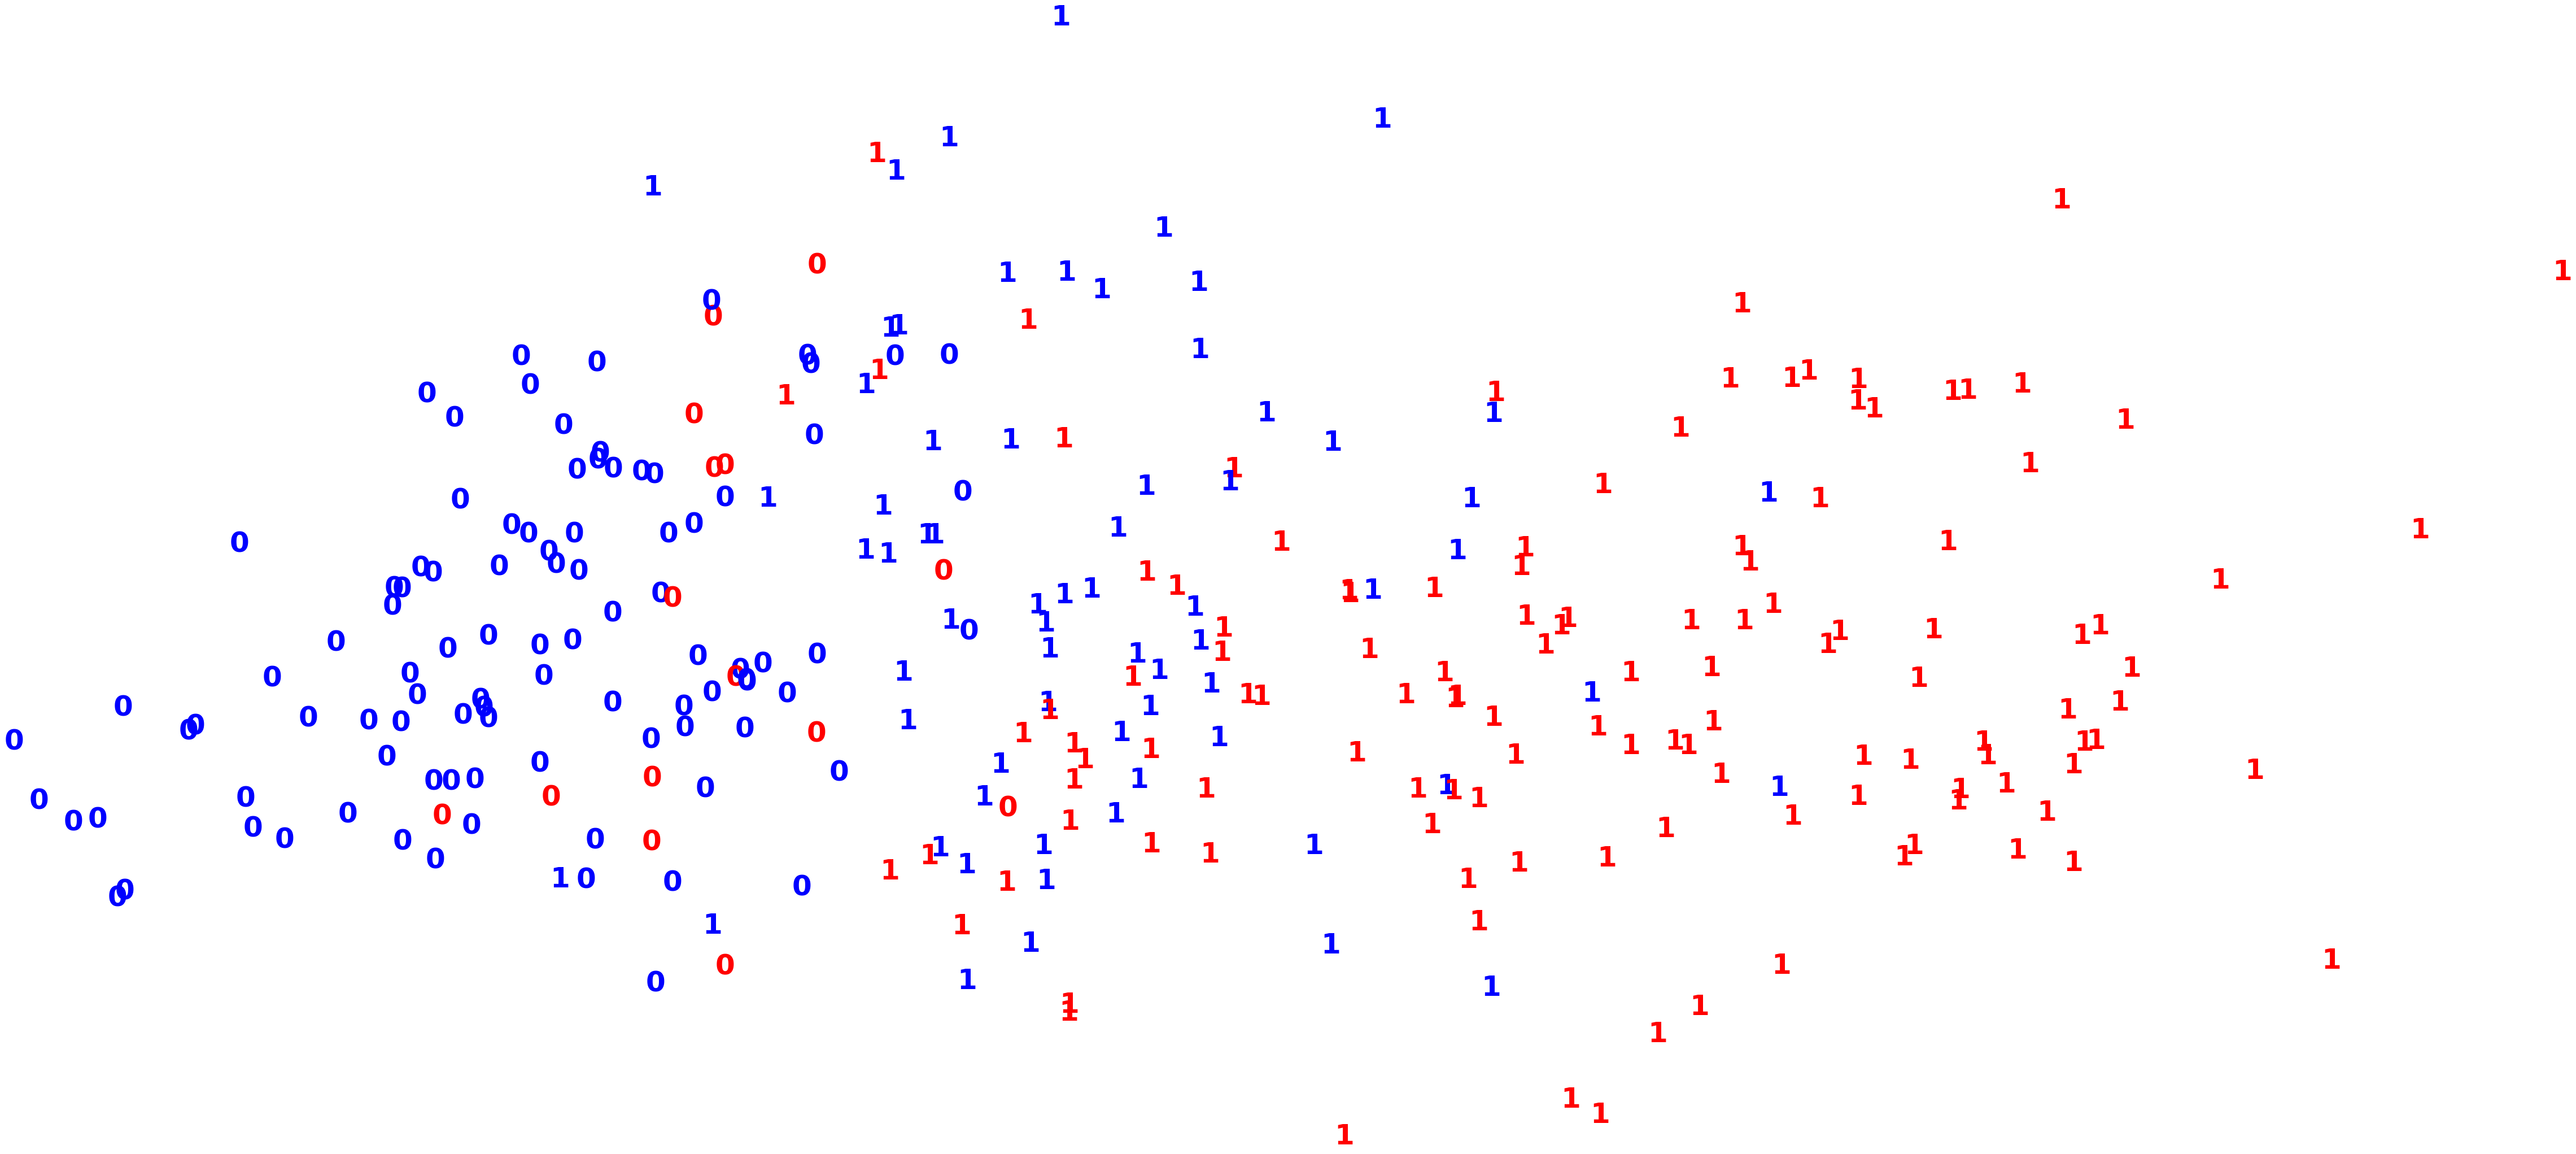

Adjusted Rand Index of the GMM solution: 0.2060175349560907
The silhoutte score of the GMM solution: 0.12345483213377387


In [78]:
# Defining the agglomerative clustering
gmm_cluster = GaussianMixture(n_components=2, covariance_type='spherical', random_state=123)

# Fit model
clusters = gmm_cluster.fit_predict(X_std)

pca = PCA(n_components=2).fit_transform(X_std)

plt.figure(figsize=(10,5))
colours = 'rbg'
for i in range(pca.shape[0]):
    plt.text(pca[i, 0], pca[i, 1], str(clusters[i]),
             color=colours[y[i]],
             fontdict={'weight': 'bold', 'size': 50}
        )

plt.xticks([])
plt.yticks([])
plt.axis('off')
plt.show()

print("Adjusted Rand Index of the GMM solution: {}"
      .format(metrics.adjusted_rand_score(y, clusters)))
print("The silhoutte score of the GMM solution: {}"
      .format(metrics.silhouette_score(X_std, clusters, metric='euclidean')))

In [79]:
pd.crosstab(y,clusters)

col_0   0    1
row_0         
0      15  124
1      96   67

OBS:
In term of ARI and silhoutte score spherical  covariance is better.